# Design of comparative analysis

In this notebook we benchmark the ability to recover query-specific cell phenotypes using 3 alternative designs for comparative analysis

- Perturbation + Atlas (PA design): mapping perturbed cells to an all-encompassing atlas dataset
- Perturbation + Control (PC design): mapping perturbed cells to a matched control dataset
- Perturbation + Control + Atlas (PAC design): mapping perturbed and control cells to an all-encompassing atlas dataset

We use 4 different metrics to assess the accuracy of query-specific cell detection:
- Differential abundance analysis with milo
- Uncertainty over labels, using KNN classifier as implemented in scArches
- Uncertainty over reconstructed gene expression profiles: ~ reconstruction error per cell after scArches
- Uncertainty over latent space: average distance of posterior samples to inferred position in scVI bottleneck layer


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [4]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [5]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(patchwork)

In [8]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

### Experiment set-up

```
python run_design_comparison.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${p} --outpath ${outdir}
python run_design_merge.py ${outdir}${d}/
python run_milo.py ${outdir}${d}/
```


### Parse results 

In [9]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [11]:

def _gauss_kernel(dist_nns):
    # compute standard deviation
    std_d = np.sqrt(sum(np.sqrt(dist_nns))/dist_nns.shape[0])
    # apply gaussian kernel
    adj_dist_nns = np.exp(-dist_nns/np.square(2/std_d))
    return(adj_dist_nns)

def _add_perturb_pop_info(pac_design_adata, min_perturb_cells = 10):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

def get_mean_confidence_x_nhood(adata, obs_names, confidence_col = 'conf_gex'):
    '''
    Compute average confidence per neighbourhood using a subset of cells
    '''
    nhood_mat = adata[obs_names].obsm['nhoods']
    mean_conf_nhoods = nhood_mat.T.dot(
            scipy.sparse.csr_matrix(adata.obs.loc[obs_names, confidence_col]).T)
    mean_conf_nhoods = mean_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
    mean_conf_nhoods = np.nan_to_num(mean_conf_nhoods, 0) ## zero confidence where we have no cells
    return(mean_conf_nhoods)

def add_nhood_uncertainties(pac_design_adata, ref_group):
    pac_design_adata.obs['uncertainty_z'] = 1 - _gauss_kernel(pac_design_adata.obs['uncertainty_z'])
    pac_design_adata.obs['conf_labels'] = 1 - pac_design_adata.obs['uncertainty_labels']
    pac_design_adata.obs['conf_gex'] = 1 - pac_design_adata.obs['uncertainty_gex']
    pac_design_adata.obs['conf_z'] = 1 - pac_design_adata.obs['uncertainty_z']

    for c in ['conf_gex', 'conf_labels', 'conf_z']:
        get_nhood_adata(pac_design_adata).obs[c] = get_mean_confidence_x_nhood(
            pac_design_adata, 
            obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] != ref_group], confidence_col=c)


In [12]:

nhood_obs_all = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if not x.endswith('.h5ad') and x.startswith('qPBMC')]:
    perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad', backed=True)
    pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad', backed=True)
    pc_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pc_design.h5ad', backed=True)

    ### Define true positive neighbourhoods
    _add_perturb_pop_info(pac_design_adata)
    _add_perturb_pop_info(pa_design_adata)
    _add_perturb_pop_info(pc_design_adata)

    # ## Calculate avg confidence per nhood
    print(f'Calculating avg confidence')
    add_nhood_uncertainties(pac_design_adata, ref_group='atlas')
    add_nhood_uncertainties(pa_design_adata, ref_group='atlas')
    add_nhood_uncertainties(pc_design_adata, ref_group='ctrl')

    ## Store nhood info
    des_dict = {'PAC':pac_design_adata, "PA": pa_design_adata, "PC": pc_design_adata}
    for design, adata in des_dict.items():
        nhood_obs = get_nhood_adata(adata).obs.copy()
        nhood_obs['design'] = design
        nhood_obs['perturb_pop'] = perturb_pop
        nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

Reading memory_B_cell

Calculating avg confidence


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Reading conventional_dendritic_cell

Calculating avg confidence
Reading naive_B_cell

Calculating avg confidence
Reading central_memory_CD4_positive_alpha_beta_T_cell

Calculating avg confidence
Reading plasmablast

Calculating avg confidence
Reading platelet

Calculating avg confidence
Reading plasmacytoid_dendritic_cell

Calculating avg confidence
Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell

Calculating avg confidence
Reading classical_monocyte

Calculating avg confidence
Reading erythrocyte

Calculating avg confidence
Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell

Calculating avg confidence
Reading natural_killer_cell

Calculating avg confidence
Reading effector_memory_CD8_positive_alpha_beta_T_cell

Calculating avg confidence
Reading mucosal_invariant_T_cell

Calculating avg confidence
Reading CD14_low_CD16_positive_monocyte

Calculating avg confidence


In [13]:
nhood_obs_all.to_csv(outdir + 'design_comparison.nhood_obs_all.csv')

In [10]:
nhood_obs_all = pd.read_csv(outdir + 'design_comparison.nhood_obs_all.csv', index_col=0)

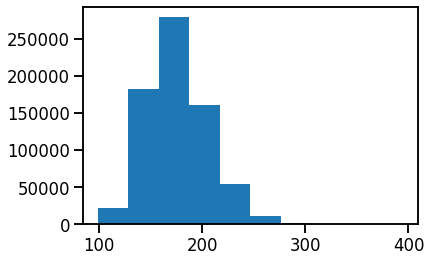

In [30]:
plt.hist(
    nhood_obs_all[nhood_obs_all.design == 'PA']['n_cells'],
);

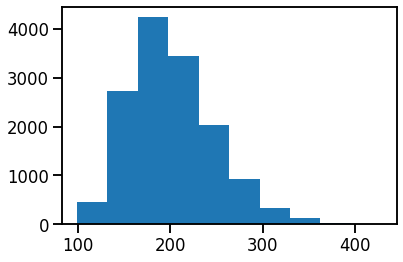

In [31]:
plt.hist(
    nhood_obs_all[nhood_obs_all.design == 'PAC']['n_cells'],
);

In [34]:
nhood_obs_all.groupby(['design', 'is_perturb_nhood']).size()

design  is_perturb_nhood
PA      False               712395
        True                   451
PAC     False                13541
        True                   811
PC      False                14811
        True                   938
dtype: int64

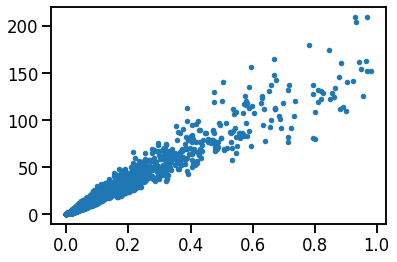

In [29]:
plt.plot(
    nhood_obs_all[nhood_obs_all.design == 'PA']['frac_perturb_cells'],
    nhood_obs_all[nhood_obs_all.design == 'PA']['n_perturb_cells'],
    '.'
);

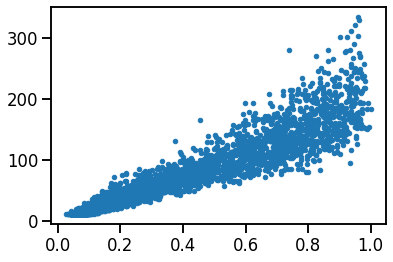

In [21]:
plt.plot(
    nhood_obs_all[nhood_obs_all.is_perturb_nhood]['frac_perturb_cells'],
    nhood_obs_all[nhood_obs_all.is_perturb_nhood]['n_perturb_cells'],
    '.'
);

In [22]:
nhood_obs_all.is_perturb_nhood = nhood_obs_all.frac_perturb_cells > 0.2

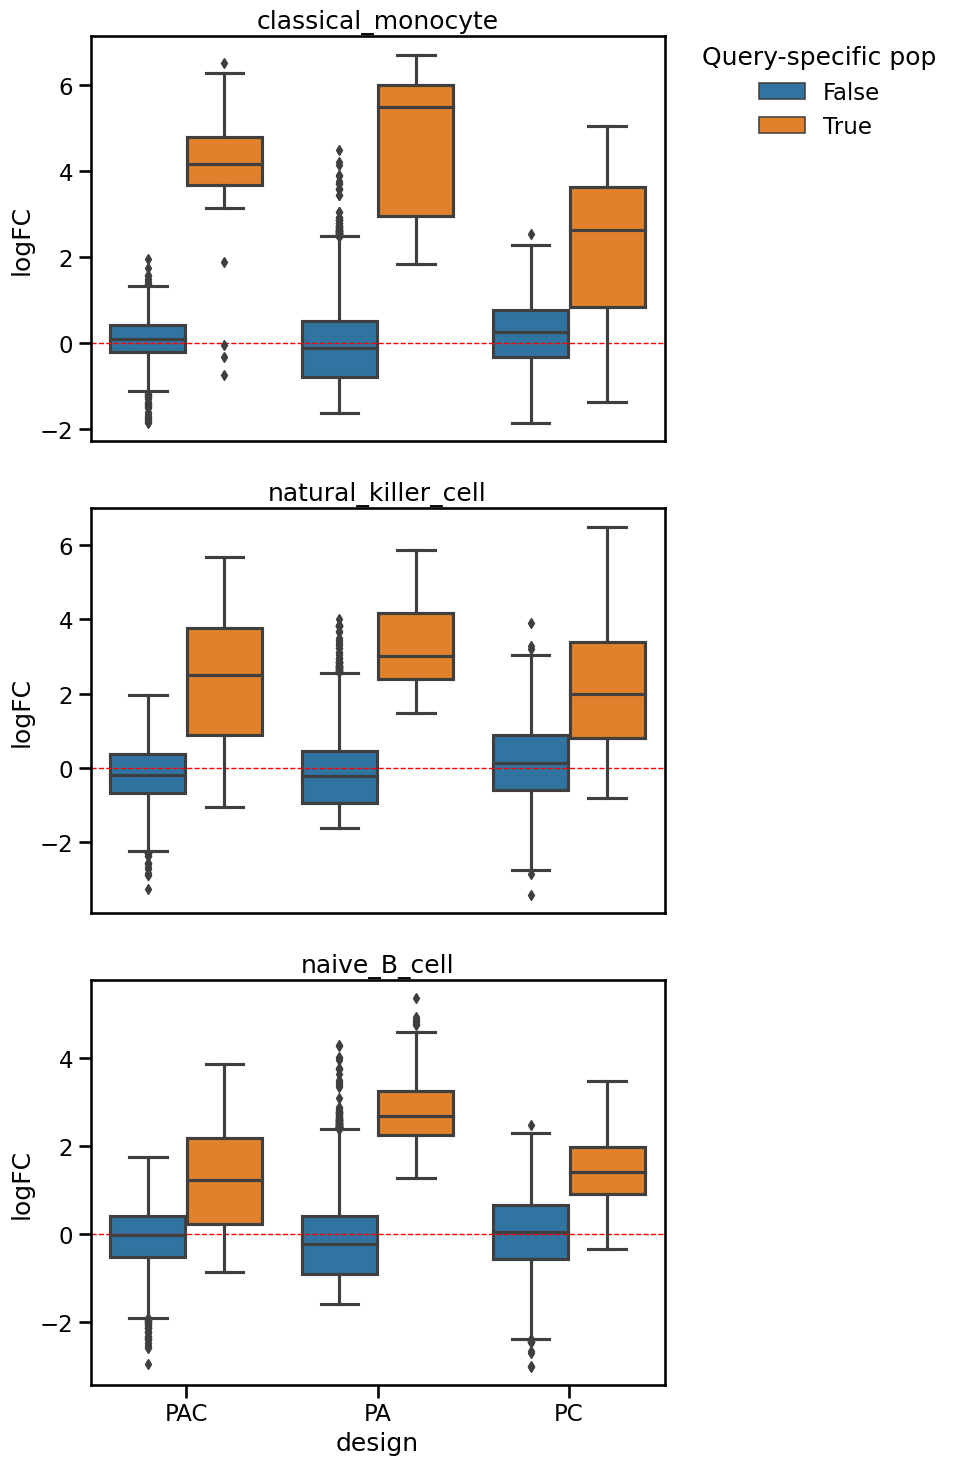

In [17]:
# cts = nhood_obs_all.perturb_pop.unique()
cts = ['classical_monocyte', 'natural_killer_cell', 'naive_B_cell']
with rc_context({'figure.figsize':[10,15]}):
    fig,axs = plt.subplots(len(cts), 1)
    for i, ct in enumerate(cts):
        axs[i].axhline(y=0, color='r', linewidth=1, linestyle='--');
        sns.boxplot(
            data=nhood_obs_all[nhood_obs_all['perturb_pop'] == ct], 
            hue='is_perturb_nhood', y='logFC', x='design', ax=axs[i]
        );
        if i == 0:
            axs[i].legend(
                bbox_to_anchor=(1.05, 1), 
                loc='upper left', 
                borderaxespad=0,
                frameon=False,
                title='Query-specific pop');
        else:
            axs[i].legend([],[], frameon=False)
        if i < (len(axs)-1):
            remove_x_axis(axs[i])
        axs[i].set_title(ct)
    fig.tight_layout()
    fig.savefig(figdir + 'DAlogFC_boxplot.png');
    

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


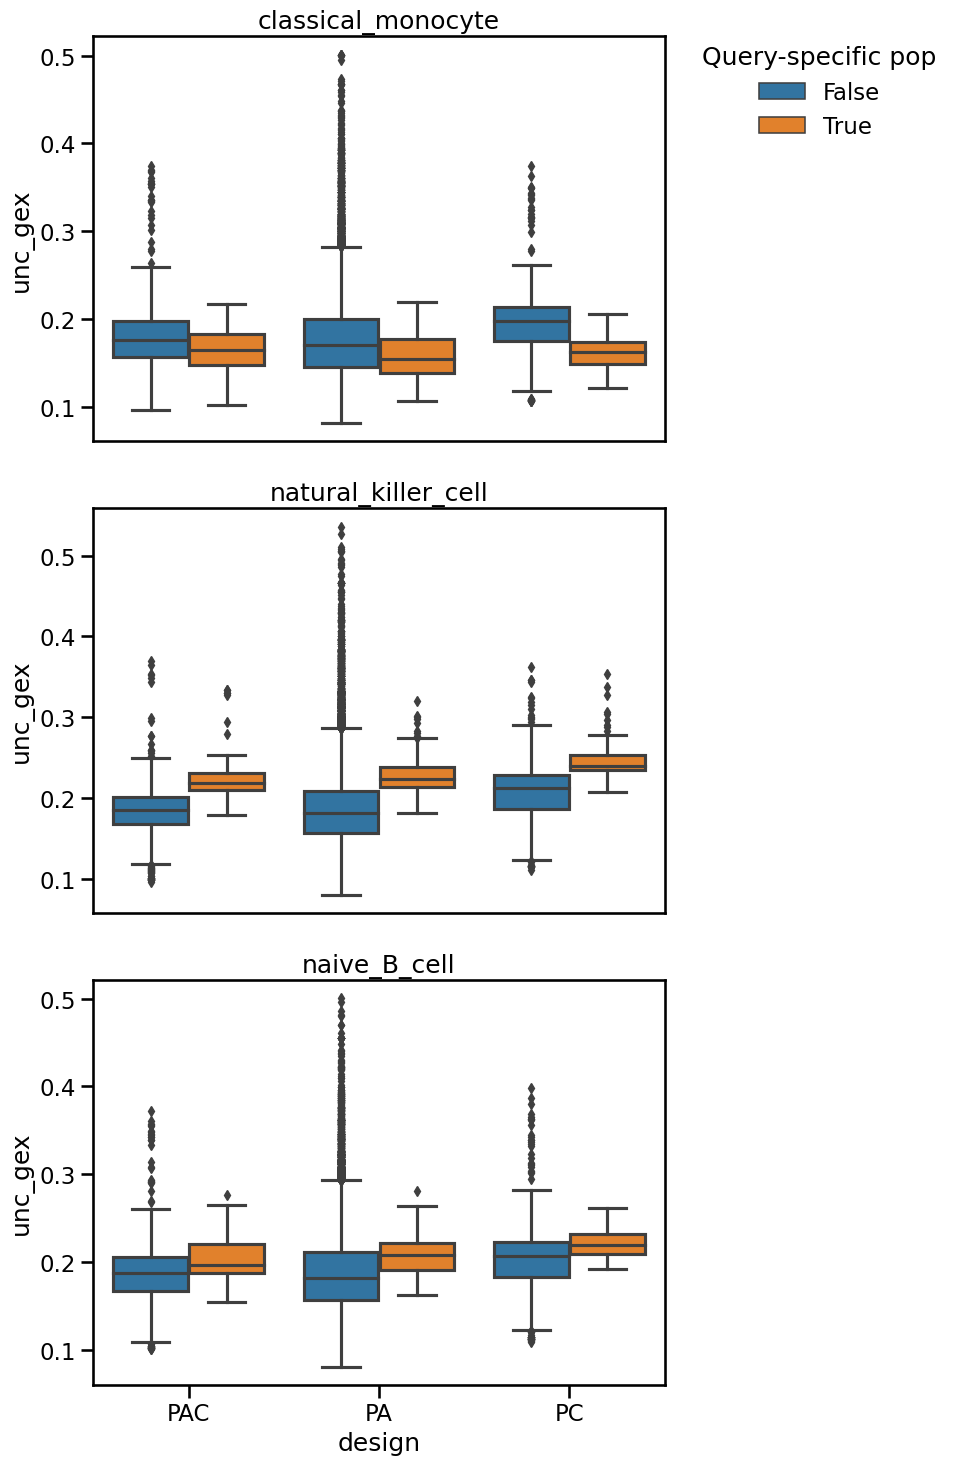

In [15]:
nhood_obs_all.conf_gex[nhood_obs_all.conf_gex == 0] = np.nan
nhood_obs_all.conf_labels[nhood_obs_all.conf_labels == 0] = np.nan

nhood_obs_all['unc_gex'] = 1 - nhood_obs_all['conf_gex']
nhood_obs_all['unc_labels'] = 1 - nhood_obs_all['conf_labels']

with rc_context({'figure.figsize':[10,15]}):
    fig,axs = plt.subplots(len(cts), 1)
    for i, ct in enumerate(cts):
        sns.boxplot(
            data=nhood_obs_all[nhood_obs_all['perturb_pop'] == ct], 
            hue='is_perturb_nhood', y='unc_gex', x='design', ax=axs[i]
        );
        if i == 0:
            axs[i].legend(
                bbox_to_anchor=(1.05, 1), 
                loc='upper left', 
                borderaxespad=0,
                frameon=False,
                title='Query-specific pop');
        else:
            axs[i].legend([],[], frameon=False)
        if i < (len(axs)-1):
            remove_x_axis(axs[i])
        axs[i].set_title(ct)
    fig.tight_layout()
    fig.savefig(figdir + 'unc_gex_boxplot.png');

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


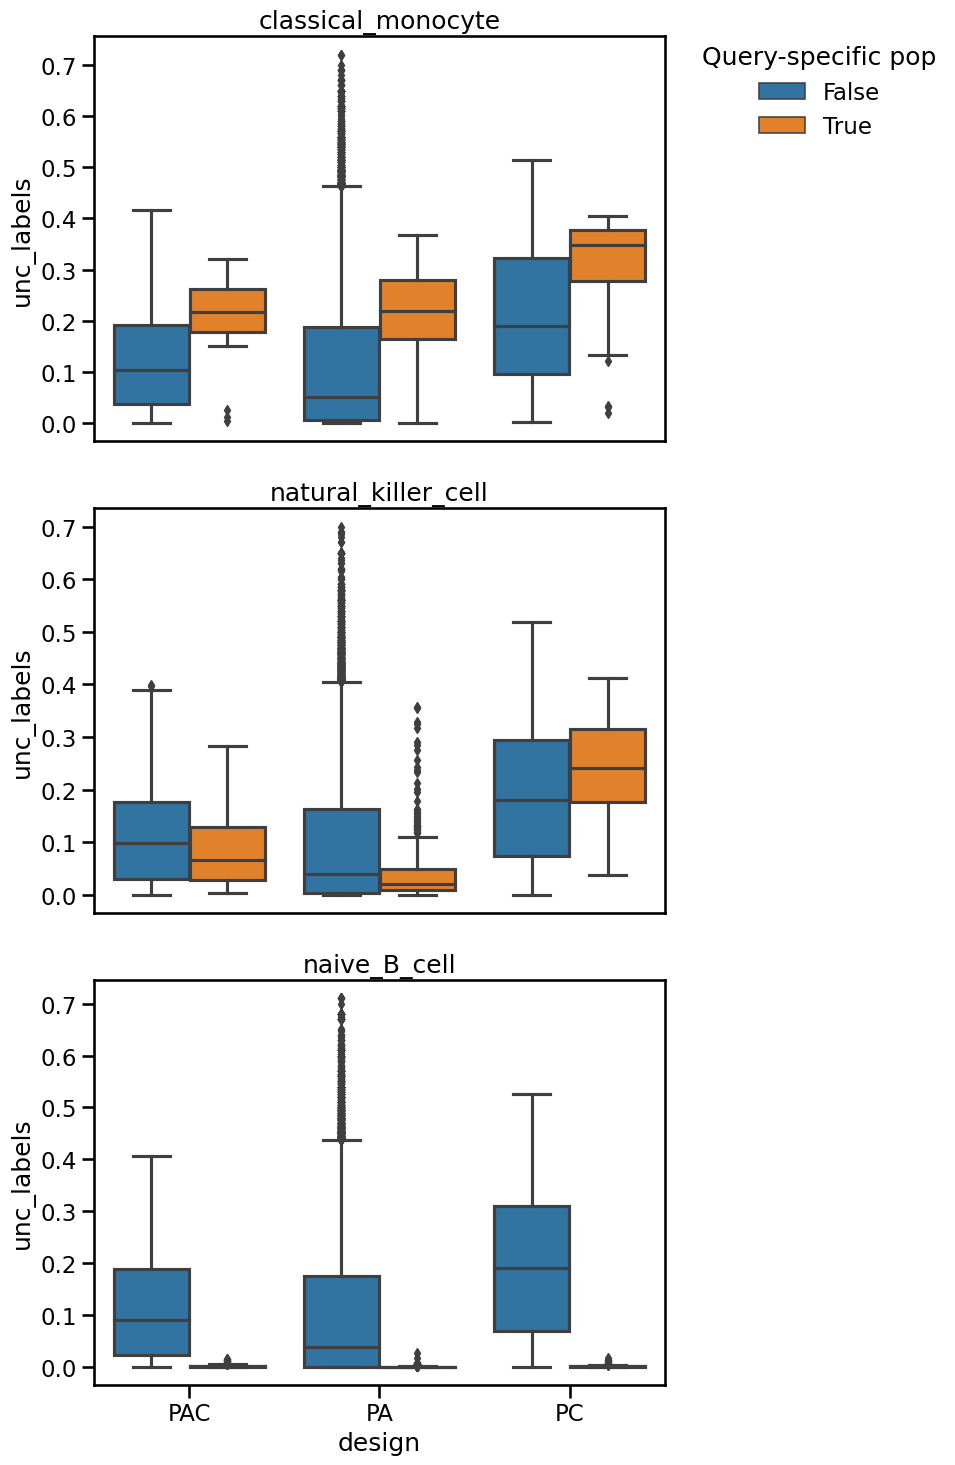

In [16]:
nhood_obs_all.conf_gex[nhood_obs_all.conf_gex == 0] = np.nan
nhood_obs_all.conf_labels[nhood_obs_all.conf_labels == 0] = np.nan
with rc_context({'figure.figsize':[10,15]}):
    fig,axs = plt.subplots(len(cts), 1)
    for i, ct in enumerate(cts):
        sns.boxplot(
            data=nhood_obs_all[nhood_obs_all['perturb_pop'] == ct], 
            hue='is_perturb_nhood', y='unc_labels', x='design', ax=axs[i]
        );
        if i == 0:
            axs[i].legend(
                bbox_to_anchor=(1.05, 1), 
                loc='upper left', 
                borderaxespad=0,
                frameon=False,
                title='Query-specific pop');
        else:
            axs[i].legend([],[], frameon=False)
        if i < (len(axs)-1):
            remove_x_axis(axs[i])
        axs[i].set_title(ct)
    fig.tight_layout()
    fig.savefig(figdir + 'unc_labels_boxplot.png');

### Quantify TPR/FPR

In [26]:
def _compute_metric_AUROC(out_df_full, metric):
    from sklearn.metrics import roc_curve,auc
    AUROC_df_all = pd.DataFrame()
    for i,c in enumerate(out_df_full['perturb_pop'].unique()):
        out_df = out_df_full[out_df_full['perturb_pop'] == c]
        fpr, tpr, _ = roc_curve(out_df.is_perturb_nhood, out_df[metric])
        AUC  = auc(fpr, tpr)
        AUROC_df = pd.DataFrame(np.vstack([fpr, tpr]), index=['FPR','TPR']).T
        AUROC_df['AUROC'] = AUC
        AUROC_df['perturb_pop'] = c
        AUROC_df_all = pd.concat([AUROC_df_all, AUROC_df])
    AUROC_df_all['metric'] = metric
    return(AUROC_df_all)

nhood_obs_all['unc_gex'] = 1 - nhood_obs_all['conf_gex']
nhood_obs_all['unc_labels'] = 1 - nhood_obs_all['conf_labels']
AUROC_df_all = pd.DataFrame()
for d in ['PAC', "PA", "PC"]:
    AUROC_conf_gex_df = _compute_metric_AUROC(nhood_obs_all[nhood_obs_all.design == d].dropna(), 'unc_gex')
    AUROC_conf_labels_df = _compute_metric_AUROC(nhood_obs_all[nhood_obs_all.design == d].dropna(), 'unc_labels')
    AUROC_logFC_df = _compute_metric_AUROC(nhood_obs_all[nhood_obs_all.design == d].dropna(), 'logFC')
    AUROC_df = pd.concat([AUROC_logFC_df, AUROC_conf_labels_df, AUROC_conf_gex_df])
    AUROC_df['design'] = d
    AUROC_df_all = pd.concat([AUROC_df_all, AUROC_df])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [27]:
%%R -i AUROC_df_all
unique(AUROC_df_all$perturb_pop)

 [1] "memory_B_cell"                                      
 [2] "conventional_dendritic_cell"                        
 [3] "naive_B_cell"                                       
 [4] "central_memory_CD4_positive_alpha_beta_T_cell"      
 [5] "plasmablast"                                        
 [6] "platelet"                                           
 [7] "plasmacytoid_dendritic_cell"                        
 [8] "naive_thymus_derived_CD4_positive_alpha_beta_T_cell"
 [9] "classical_monocyte"                                 
[10] "erythrocyte"                                        
[11] "naive_thymus_derived_CD8_positive_alpha_beta_T_cell"
[12] "natural_killer_cell"                                
[13] "effector_memory_CD8_positive_alpha_beta_T_cell"     
[14] "mucosal_invariant_T_cell"                           
[15] "CD14_low_CD16_positive_monocyte"                    


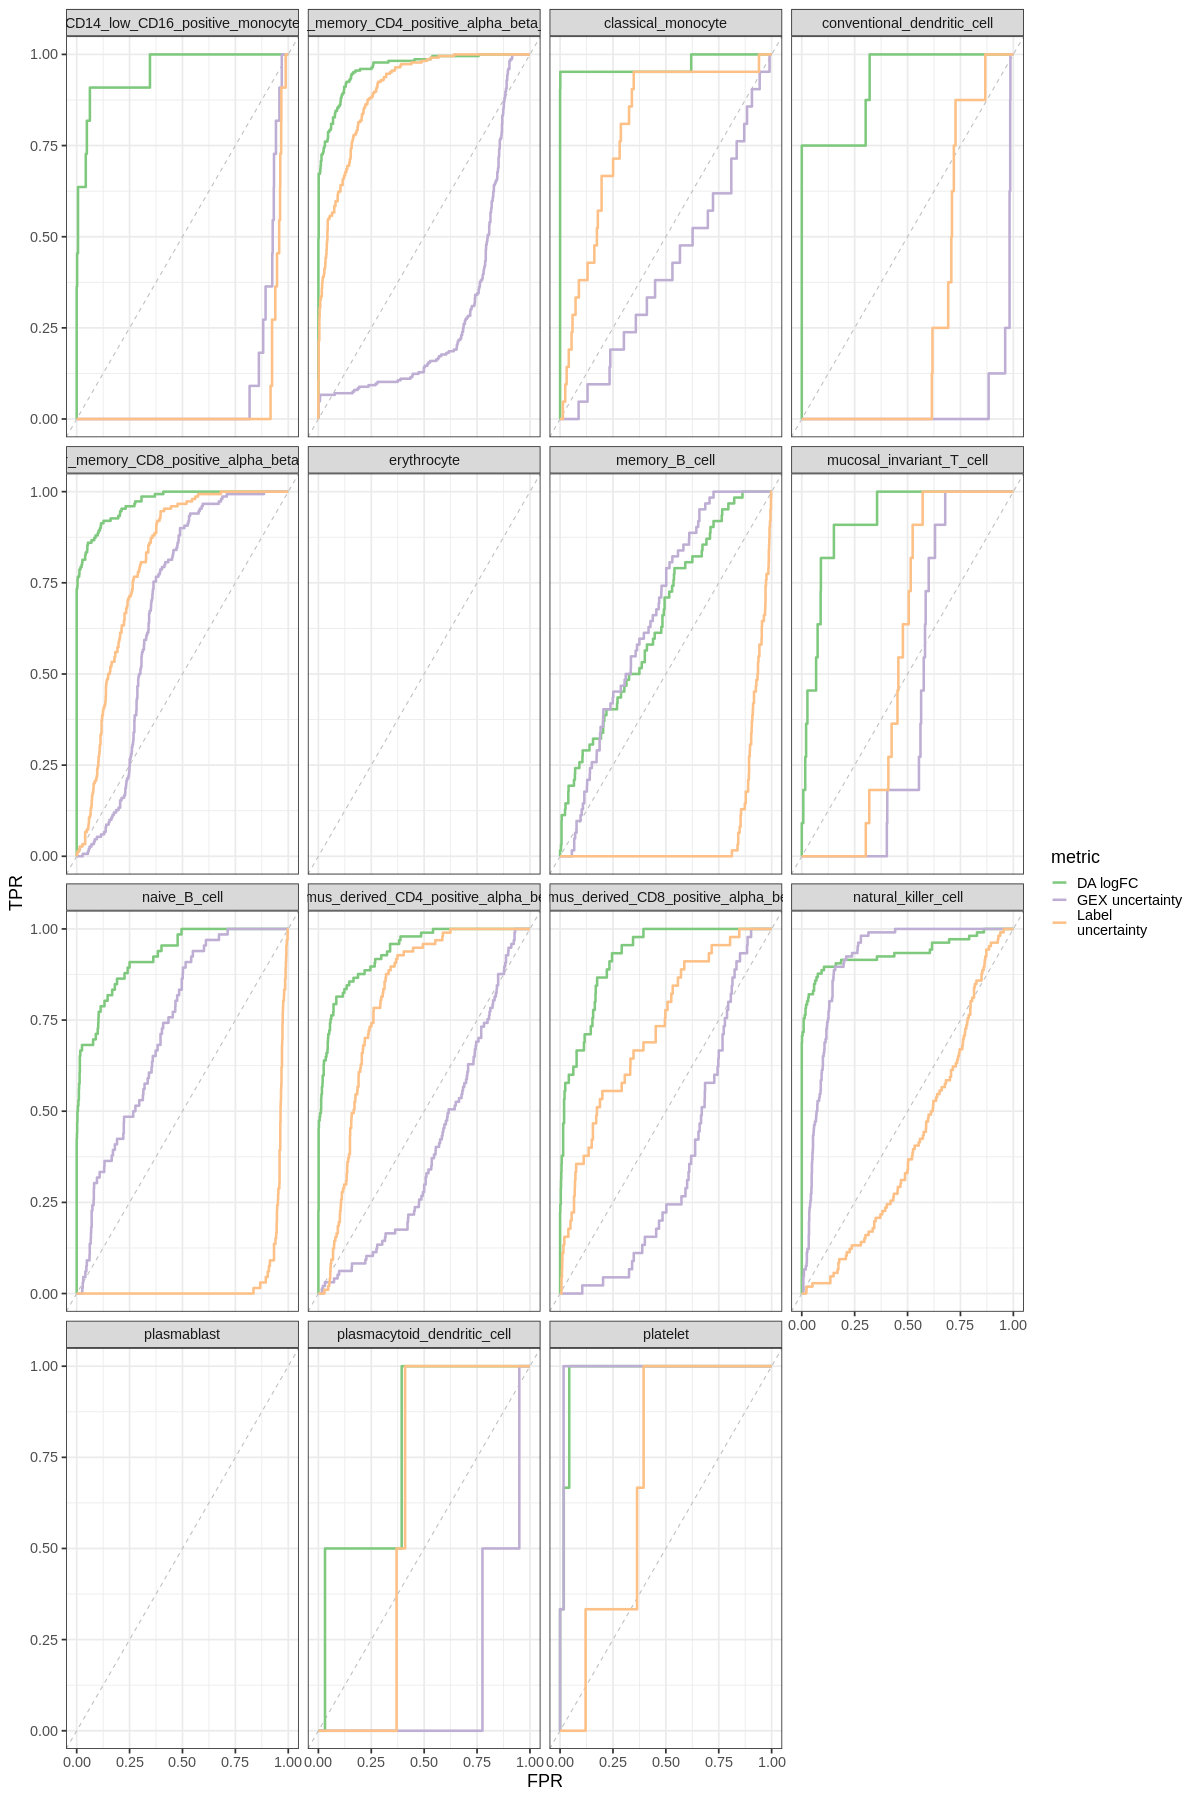

In [28]:
%%R -i figdir -w 1200 -h 1800
AUROC_df_all %>%
    filter(design=='PAC') %>%
    ggplot(aes( FPR, TPR, group=metric, color=metric)) +
        geom_abline(linetype=2, color='grey') +
        geom_line(size=1.2) +
        facet_wrap(perturb_pop~.) +
        scale_color_brewer(palette='Accent', labels=setNames(c('GEX uncertainty', 'Label\nuncertainty', 'DA logFC'), c('unc_gex', 'unc_labels', 'logFC'))) +
        theme_bw(base_size=18) +
        ggsave(paste0(figdir, 'AUROC_PAC_vs_uncertainty.png'), width=12, height=12)

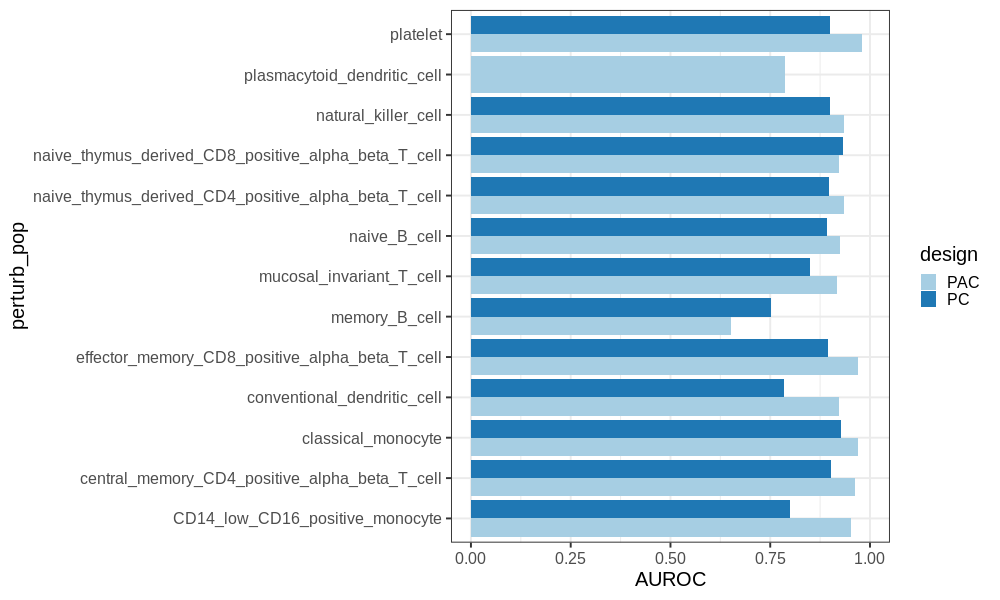

In [35]:
%%R -i figdir -w 1000 -h 600
AUROC_df_all %>%
    filter(design!='PA') %>%
    filter(metric=='logFC') %>%
    filter(!is.na(AUROC)) %>%
    ggplot(aes( perturb_pop, AUROC, fill=design)) +
        geom_col(position='dodge') +
        scale_fill_brewer(palette='Paired') +
        theme_bw(base_size=20) +
        ylim(0,1) +
        coord_flip() +
        ggsave(paste0(figdir, 'AUROC_PAC_vs_PC.png'), width=12, height=6)

In [18]:
cts = nhood_obs_all.perturb_pop.unique()
alpha = 0.1
nhood_obs_all['pred_positive'] = (nhood_obs_all.SpatialFDR < alpha) 
nhood_obs_all['TP'] = nhood_obs_all['pred_positive'] & (nhood_obs_all['is_perturb_nhood']) & (nhood_obs_all.logFC > 0)
nhood_obs_all['FP'] = nhood_obs_all['pred_positive'] & (~nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['FN'] = (~nhood_obs_all['pred_positive']) & (nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['TN'] = (~nhood_obs_all['pred_positive']) & (~nhood_obs_all['is_perturb_nhood'])

In [19]:
tpr_df = nhood_obs_all.groupby(['design', 'perturb_pop']).sum()[['TP', 'FP', 'FN', "TN"]].reset_index()
tpr_df['TPR'] = tpr_df['TP'] / (tpr_df['TP'] + tpr_df['FN'])
tpr_df['FPR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TN'])
tpr_df['FDR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df

,design,perturb_pop,TP,FP,FN,TN,TPR,FPR,FDR
0,PA,CD14_low_CD16_positive_monocyte,24,4308,0,45450,1.000000,0.086579,0.994460
1,PA,central_memory_CD4_positive_alpha_beta_T_cell,510,3820,0,35031,1.000000,0.098324,0.882217
2,PA,classical_monocyte,53,4382,0,43430,1.000000,0.091651,0.988050
3,PA,conventional_dendritic_cell,13,3937,0,46842,1.000000,0.077532,0.996709
4,PA,effector_memory_CD8_positive_alpha_beta_T_cell,351,3384,0,38524,1.000000,0.080748,0.906024
5,PA,erythrocyte,0,4284,0,46883,NaN,0.083726,1.000000
6,PA,memory_B_cell,70,4299,0,43929,1.000000,0.089139,0.983978
7,PA,mucosal_invariant_T_cell,14,4245,0,45644,1.000000,0.085089,0.996713
8,PA,naive_B_cell,280,3532,0,44490,1.000000,0.073550,0.926548
9,PA,naive_thymus_derived_CD4_positive_alpha_beta_T...,184,4393,0,35422,1.000000,0.110335,0.959799


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


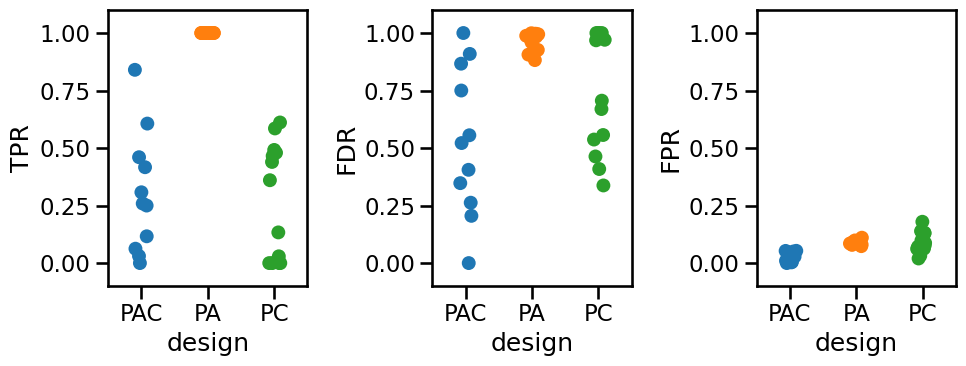

In [22]:
tpr_df = tpr_df.dropna()
tpr_df['design'] = tpr_df['design'].astype('category').cat.reorder_categories(['PAC', "PA", "PC"])
with rc_context({'figure.figsize':[10,4]}):
    plt.subplot(1,3,1)
    sns.stripplot(data=tpr_df, y='TPR', x='design', s=10);
    plt.ylim(-0.1,1.1);
    plt.subplot(1,3,2)
    sns.stripplot(data=tpr_df, y='FDR', x='design', s=10);
    plt.ylim(-0.1,1.1);
    plt.subplot(1,3,3)
    sns.stripplot(data=tpr_df, y='FPR', x='design', s=10);
    plt.ylim(-0.1,1.1);
    plt.tight_layout()
    plt.savefig(figdir+'TPR_FDR_TPR.png')

In [24]:
tpr_df

,design,perturb_pop,TP,FP,FN,TN,TPR,FPR,FDR
0,PA,CD14_low_CD16_positive_monocyte,24,4308,0,45450,1.000000,0.086579,0.994460
1,PA,central_memory_CD4_positive_alpha_beta_T_cell,510,3820,0,35031,1.000000,0.098324,0.882217
2,PA,classical_monocyte,53,4382,0,43430,1.000000,0.091651,0.988050
3,PA,conventional_dendritic_cell,13,3937,0,46842,1.000000,0.077532,0.996709
4,PA,effector_memory_CD8_positive_alpha_beta_T_cell,351,3384,0,38524,1.000000,0.080748,0.906024
6,PA,memory_B_cell,70,4299,0,43929,1.000000,0.089139,0.983978
7,PA,mucosal_invariant_T_cell,14,4245,0,45644,1.000000,0.085089,0.996713
8,PA,naive_B_cell,280,3532,0,44490,1.000000,0.073550,0.926548
9,PA,naive_thymus_derived_CD4_positive_alpha_beta_T...,184,4393,0,35422,1.000000,0.110335,0.959799
10,PA,naive_thymus_derived_CD8_positive_alpha_beta_T...,99,4068,0,43800,1.000000,0.084984,0.976242


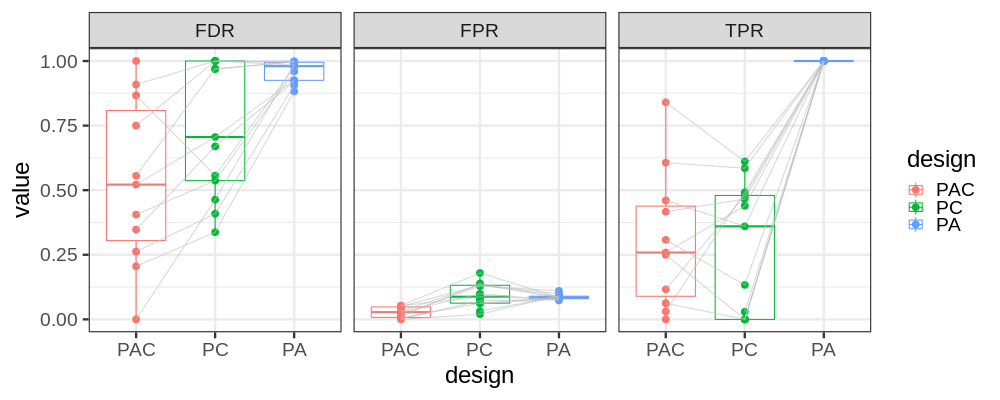

In [28]:
%%R -i tpr_df -w 1000 -h 400
tpr_df %>%
mutate(design = factor(design, levels=c("PAC","PC", "PA"))) %>%
pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
ggplot(aes(design, value, color=design)) +
geom_boxplot() +
geom_point(size=3) +
geom_line(aes(group=perturb_pop), color='grey', alpha=0.6) +
facet_wrap(metric~.) +
theme_bw(base_size=24)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


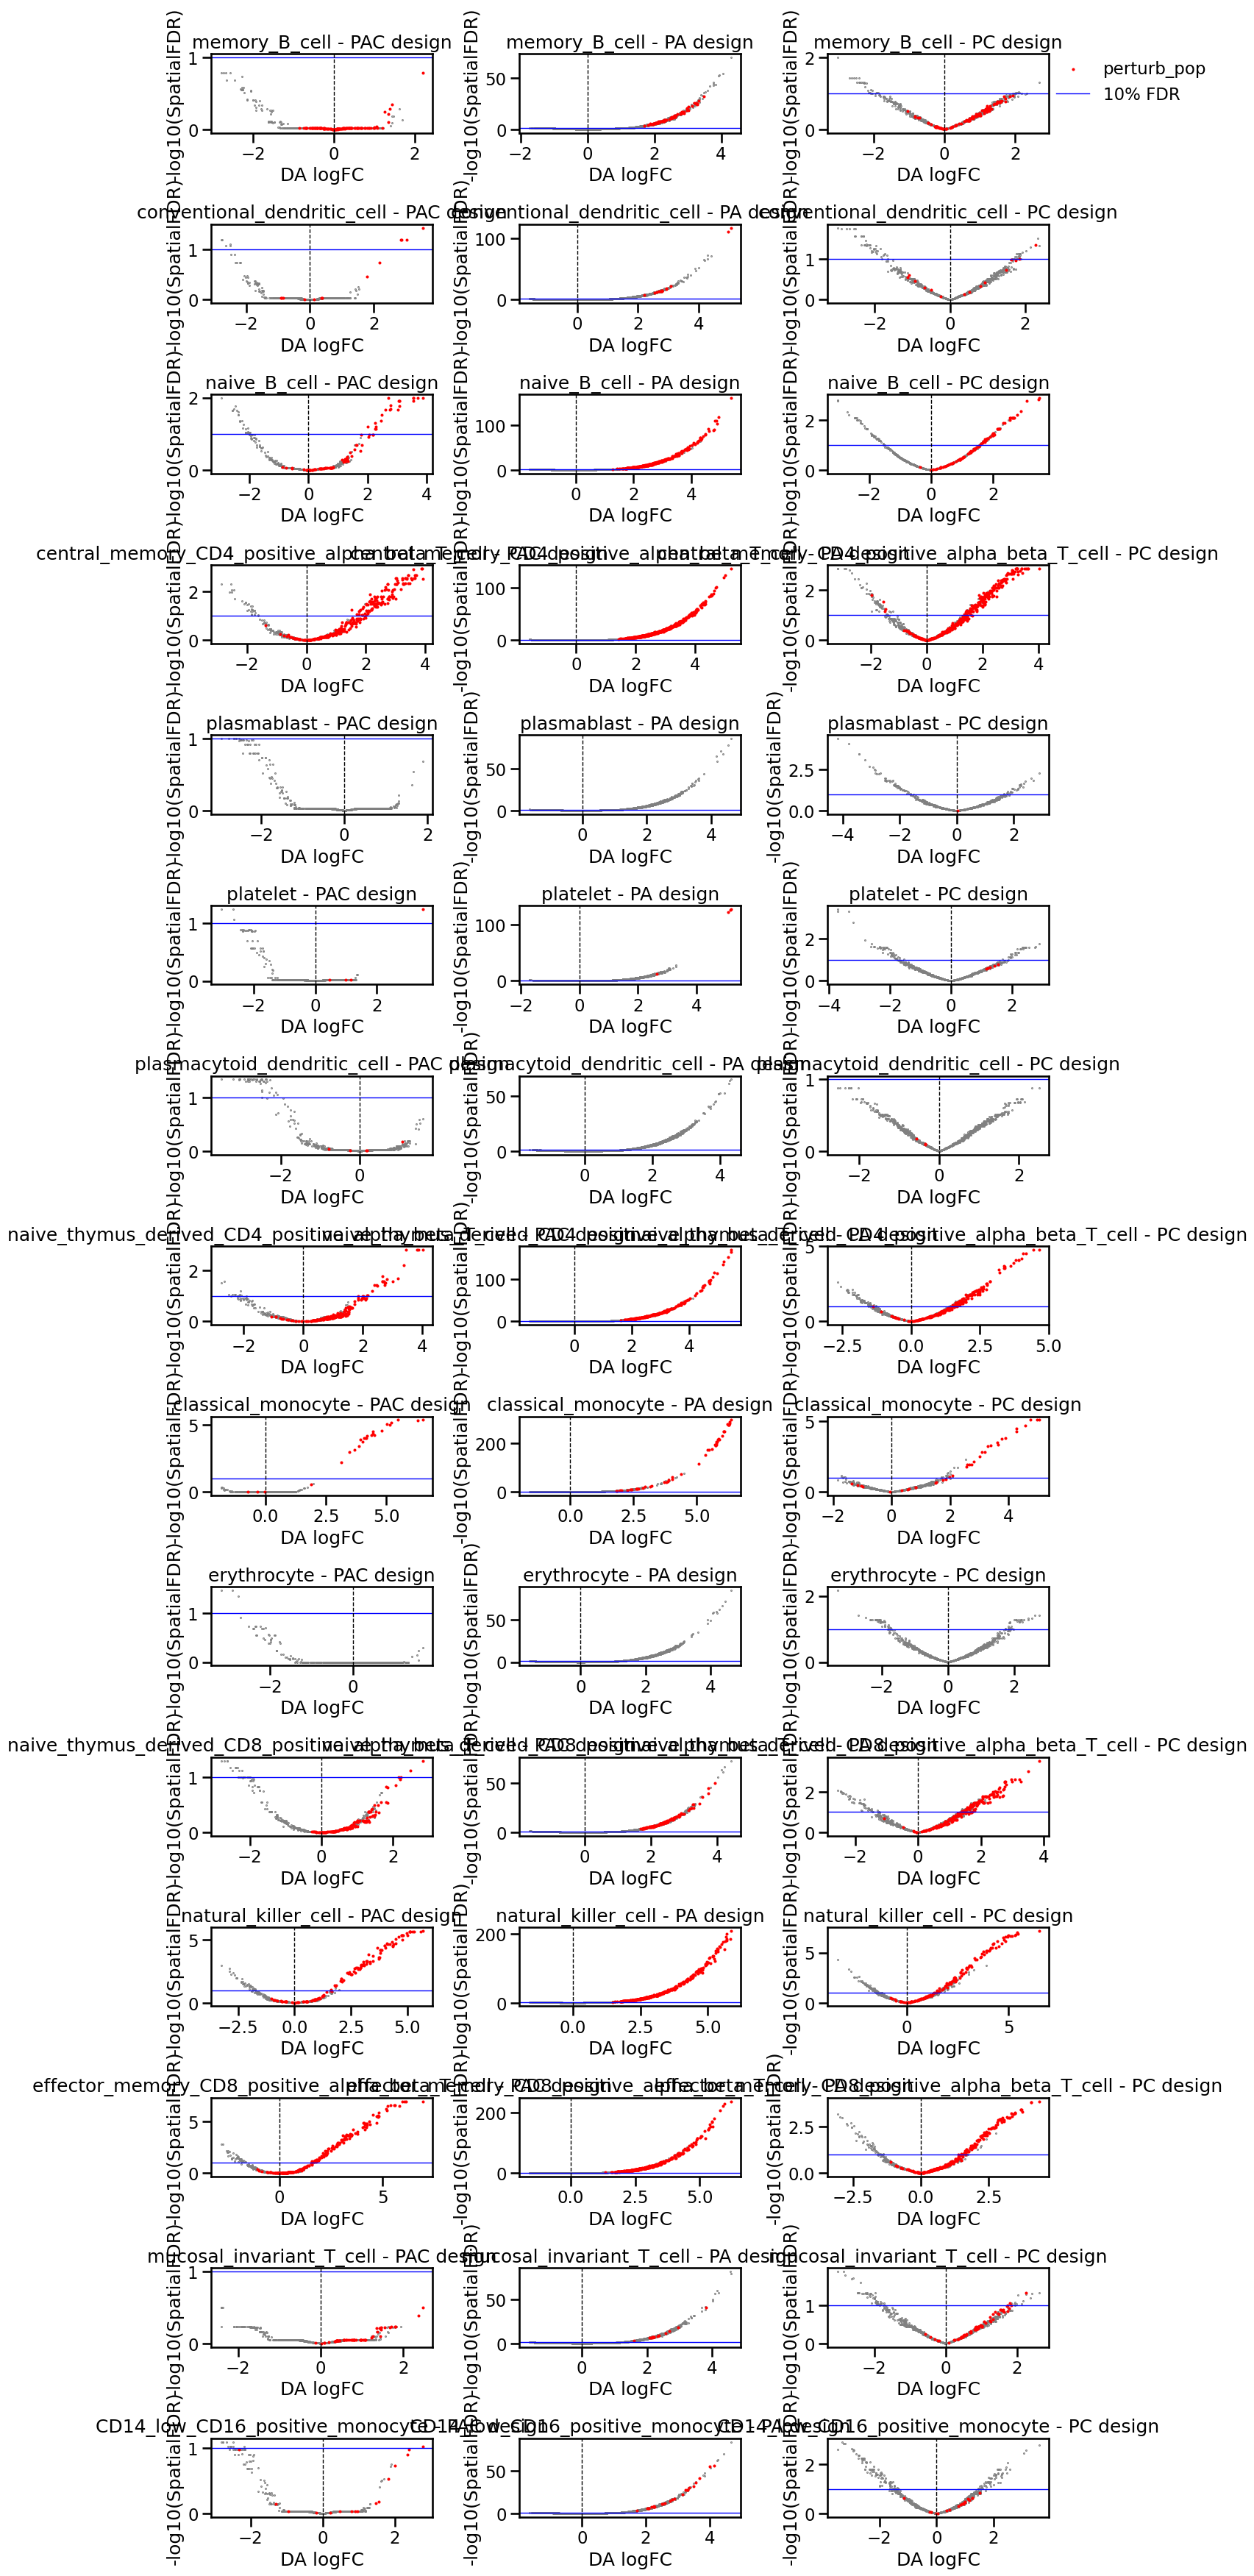

In [58]:
cts = nhood_obs_all.perturb_pop.unique()
designs = ['PAC', "PA", "PC"]
with rc_context({'figure.figsize':[15,35]}):
    fig,axs = plt.subplots(len(cts), len(designs))
    for i, ct in enumerate(cts):
        for j, d in enumerate(designs):
            df = nhood_obs_all[(nhood_obs_all['perturb_pop'] == ct) & (nhood_obs_all['design'] == d)]
            axs[i,j].scatter(df.logFC, -np.log10(df.SpatialFDR), s=0.4, color='grey');
            pos_df = df[df.is_perturb_nhood]
            axs[i,j].scatter(pos_df.logFC, -np.log10(pos_df.SpatialFDR), s=2, color='red', label='perturb_pop');
            axs[i,j].axhline(y=-np.log10(alpha), color='blue', linewidth=1, linestyle='-', label='10% FDR'); ## horizontal
            axs[i,j].axvline(x=0, color='black', linewidth=1, linestyle='--'); 
            if i==0 and j==2:
                axs[i,j].legend(bbox_to_anchor=(1.00, 1), # relative position on x and y axis (> 1 indicates outside of axis)
                    loc='upper left', # equiv to hjust/vjust in ggplot
                    borderaxespad=0, # The pad between the axes and legend border, in font-size units.
                    frameon=False);
            else:
                axs[i,j].legend([], [], frameon=False)
            axs[i,j].set_xlabel("DA logFC");
            axs[i,j].set_ylabel("-log10(SpatialFDR)");
            axs[i,j].set_title(f'{ct} - {d} design');
    fig.tight_layout();
    fig.savefig(figdir+'volcanos.png');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


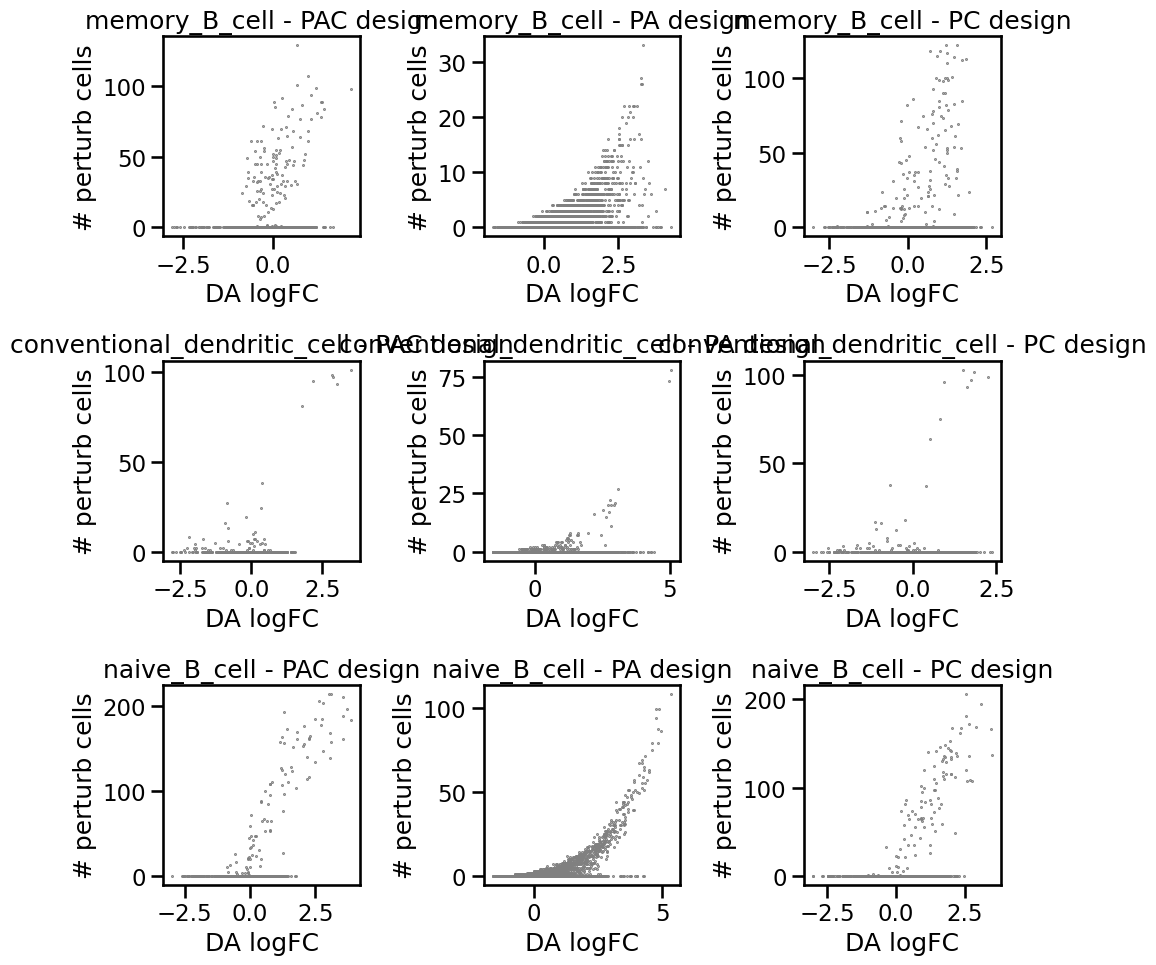

In [64]:
cts = nhood_obs_all.perturb_pop.unique()[0:3]
designs = ['PAC', "PA", "PC"]
with rc_context({'figure.figsize':[10,10]}):
    fig,axs = plt.subplots(len(cts), len(designs))
    for i, ct in enumerate(cts):
        for j, d in enumerate(designs):
            df = nhood_obs_all[(nhood_obs_all['perturb_pop'] == ct) & (nhood_obs_all['design'] == d)]
            axs[i,j].scatter(df.logFC, df.n_perturb_cells, s=0.4, color='grey');
            # pos_df = df[df.is_perturb_nhood]
            # axs[i,j].scatter(pos_df.logFC, -np.log10(pos_df.SpatialFDR), s=2, color='red', label='is significant');
            # axs[i,j].axhline(y=-np.log10(alpha), color='blue', linewidth=1, linestyle='-', label='10% FDR'); ## horizontal
            # axs[i,j].axvline(x=0, color='black', linewidth=1, linestyle='--'); 
            if i==0 and j==2:
                axs[i,j].legend(bbox_to_anchor=(1.00, 1), # relative position on x and y axis (> 1 indicates outside of axis)
                    loc='upper left', # equiv to hjust/vjust in ggplot
                    borderaxespad=0, # The pad between the axes and legend border, in font-size units.
                    frameon=False);
            else:
                axs[i,j].legend([], [], frameon=False)
            axs[i,j].set_xlabel("DA logFC");
            axs[i,j].set_ylabel("# perturb cells");
            axs[i,j].set_title(f'{ct} - {d} design');
    fig.tight_layout();
    # fig.savefig(figdir+'volcanos.png');

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


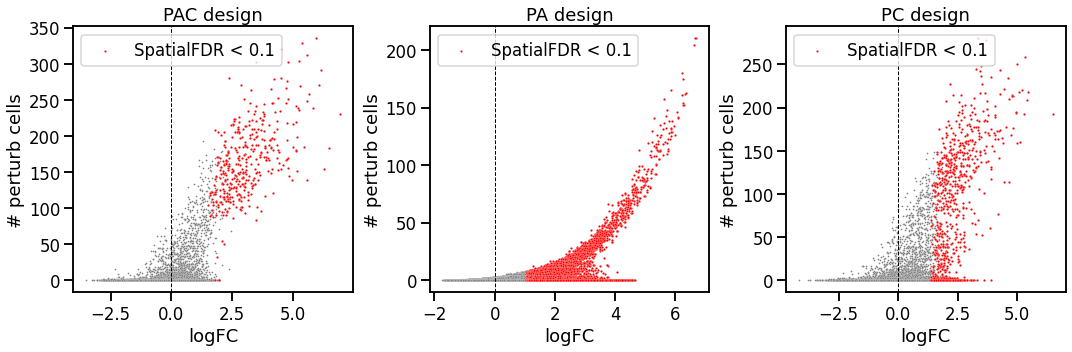

In [39]:
nhood_obs_all['signif_DA'] = (nhood_obs_all.SpatialFDR <= 0.1) & (nhood_obs_all.logFC > 0)
with rc_context({'figure.figsize':[15,5]}):
    for i,d in enumerate(['PAC', "PA", "PC"]):
        plt.subplot(1,3,i+1)
        sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design==d], x='logFC',  y='n_perturb_cells',  s=3, color='grey');
        sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.design==d) & (nhood_obs_all.signif_DA)], x='logFC',  y='n_perturb_cells',  s=5, color='red', label='SpatialFDR < 0.1');
        plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
        plt.title(f'{d} design');
        plt.ylabel("# perturb cells");
        plt.tight_layout()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


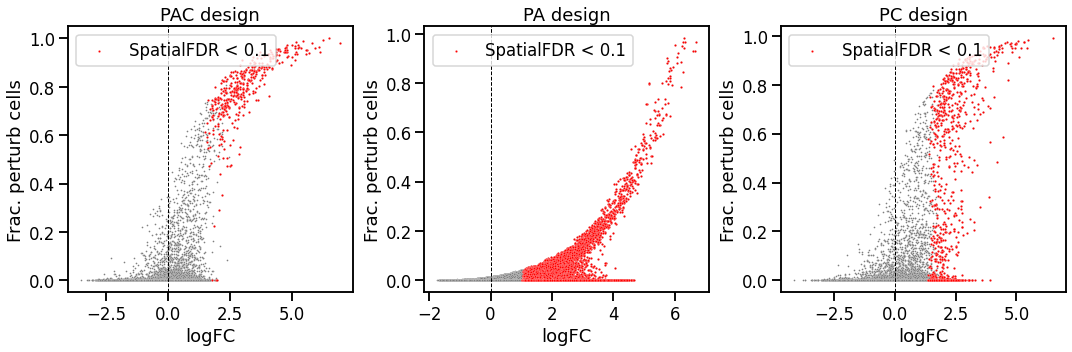

In [41]:
cts = 
nhood_obs_all['signif_DA'] = (nhood_obs_all.SpatialFDR <= 0.1) & (nhood_obs_all.logFC > 0)
with rc_context({'figure.figsize':[15,5]}):
    for i,d in enumerate(['PAC', "PA", "PC"]):
        plt.subplot(1,3,i+1)
        sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design==d], x='logFC',  y='frac_perturb_cells',  s=3, color='grey');
        sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.design==d) & (nhood_obs_all.signif_DA)], x='logFC',  y='frac_perturb_cells',  s=5, color='red', label='SpatialFDR < 0.1');
        plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
        plt.title(f'{d} design');
        plt.ylabel("Frac. perturb cells");
        plt.tight_layout()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


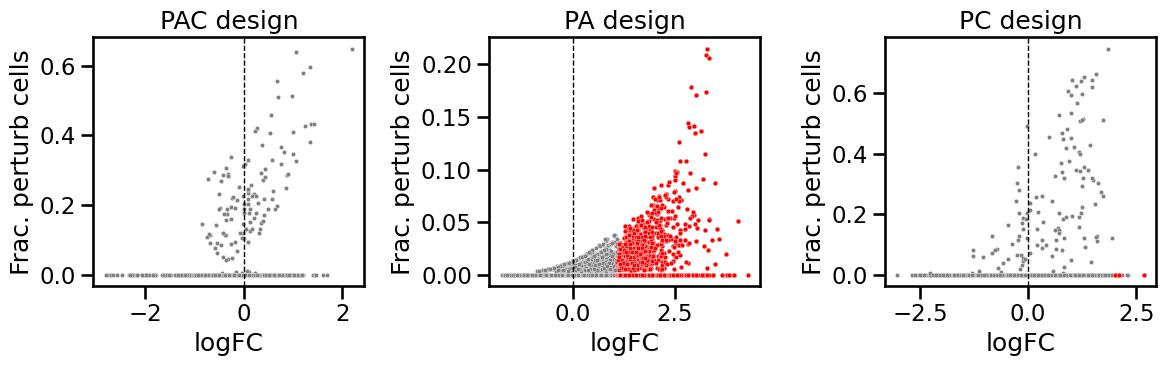

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


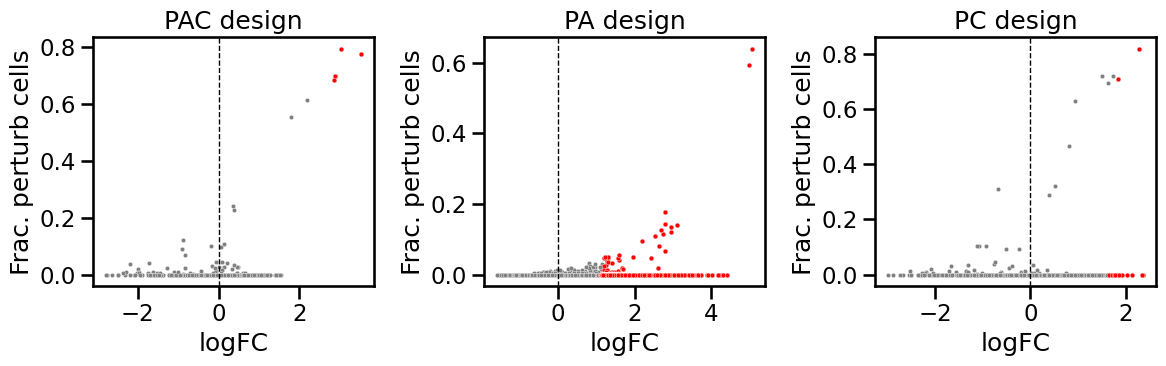

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


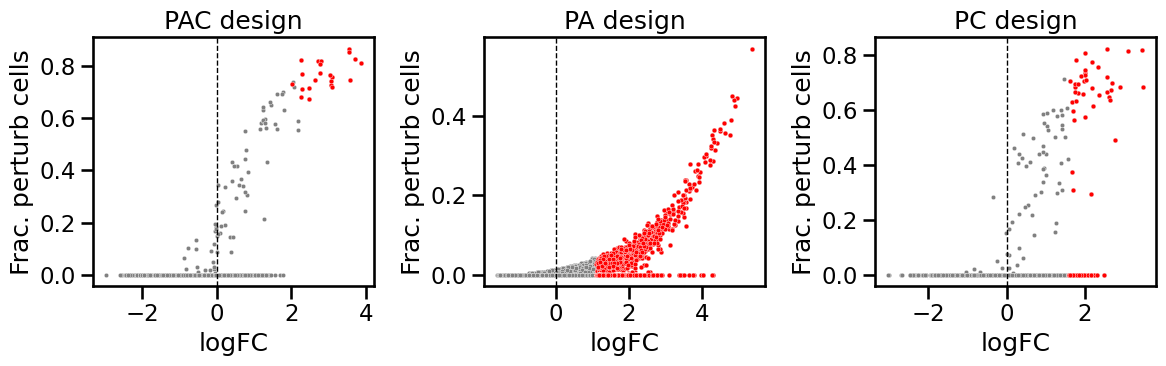

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


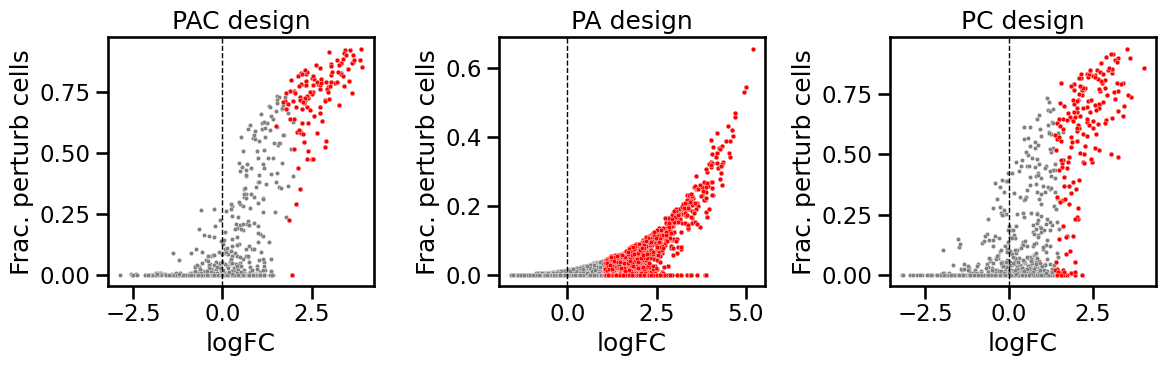

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


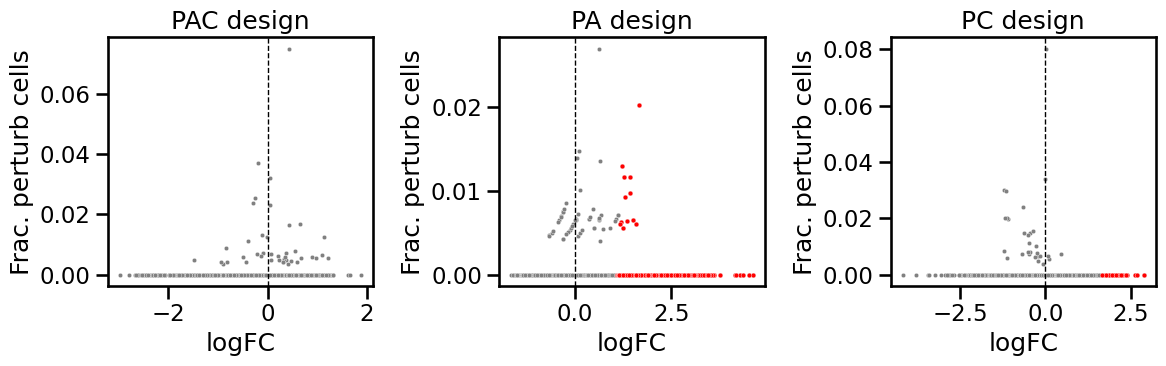

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


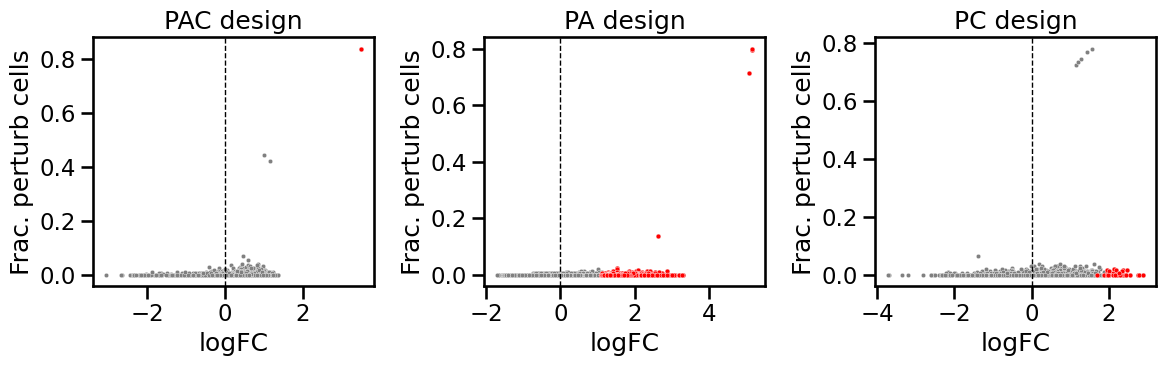

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


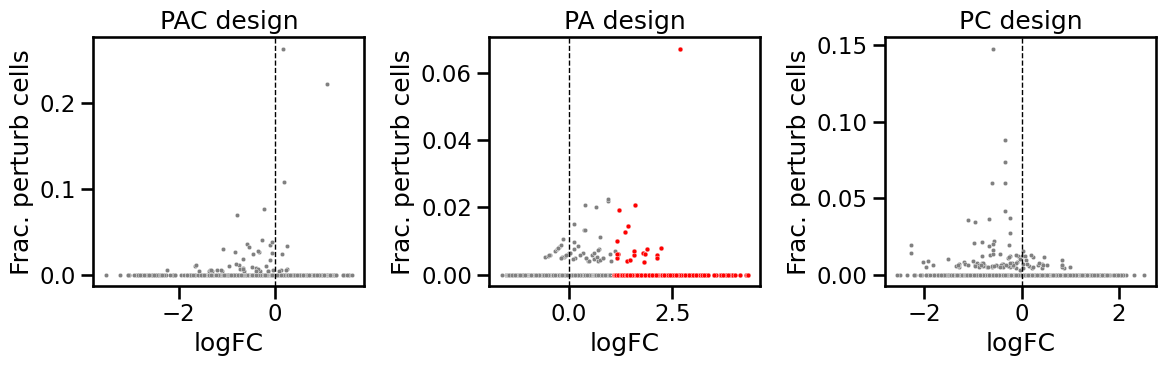

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


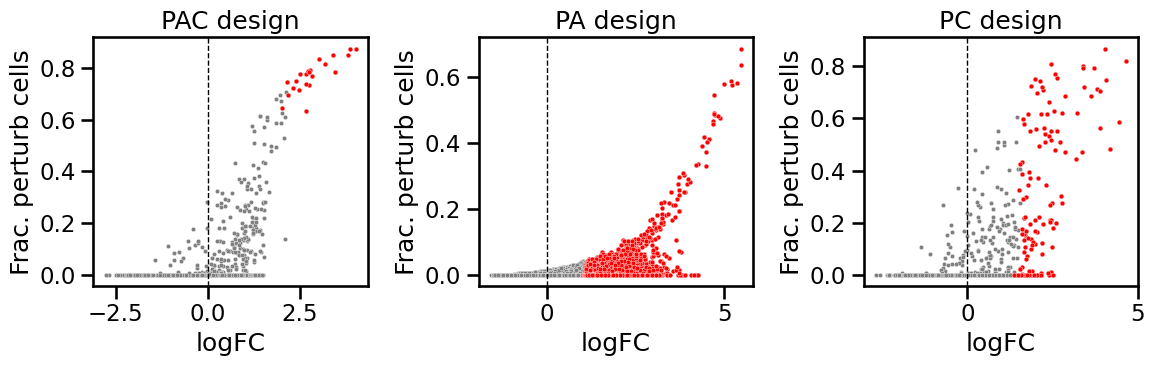

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


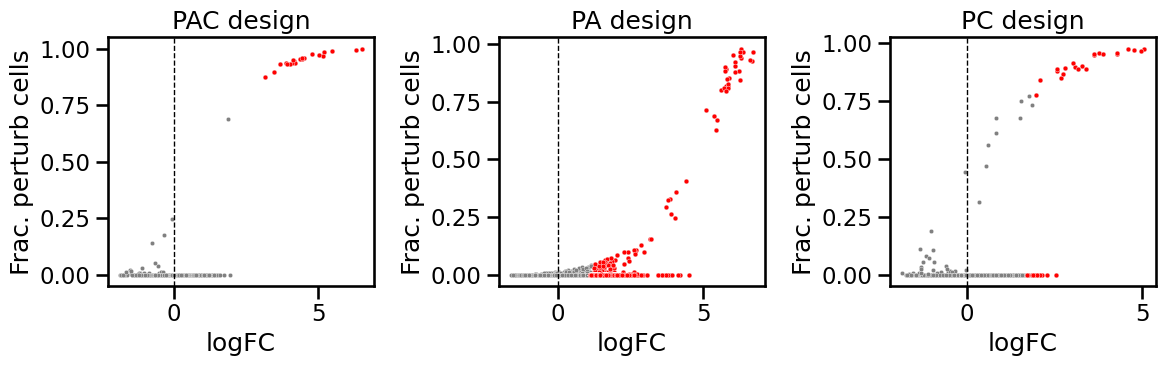

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


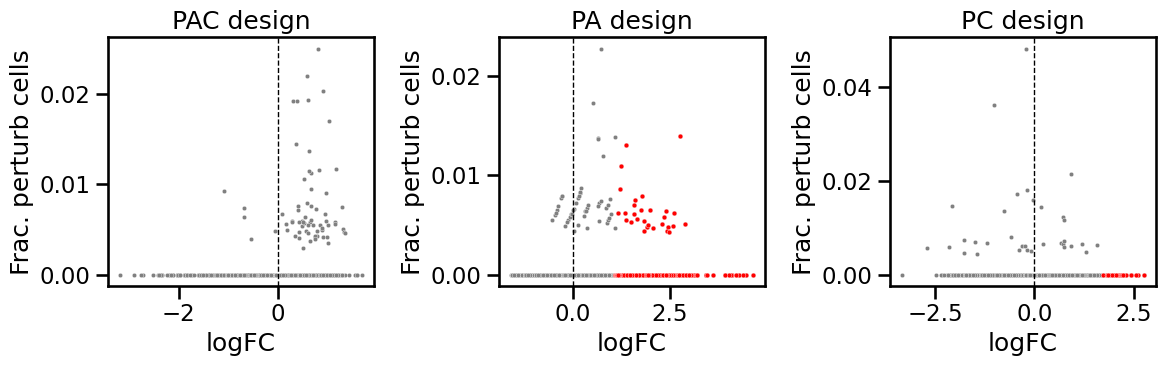

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


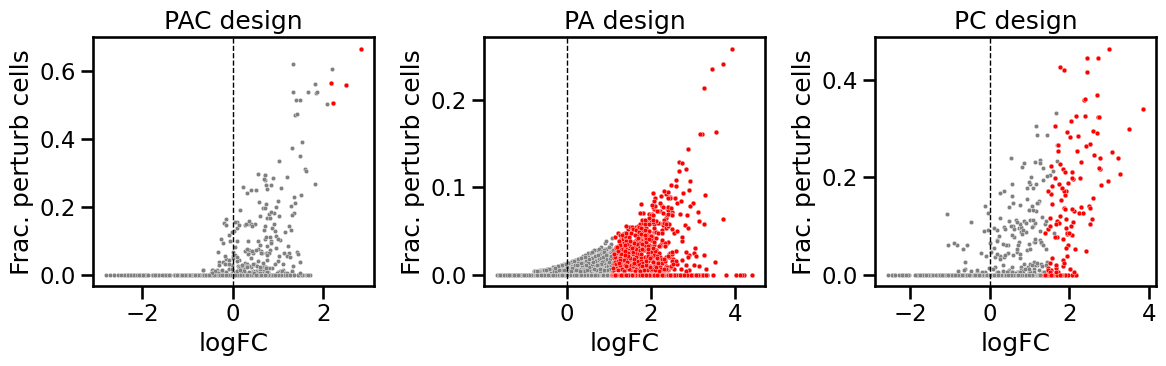

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


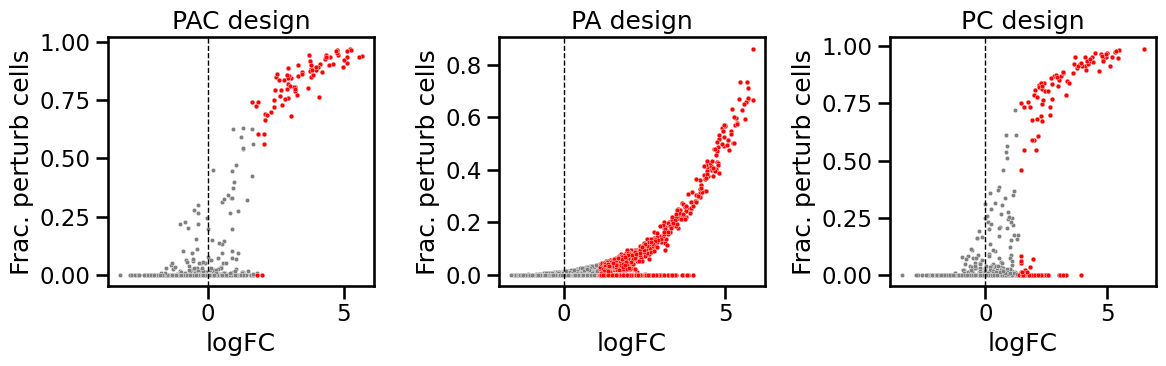

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


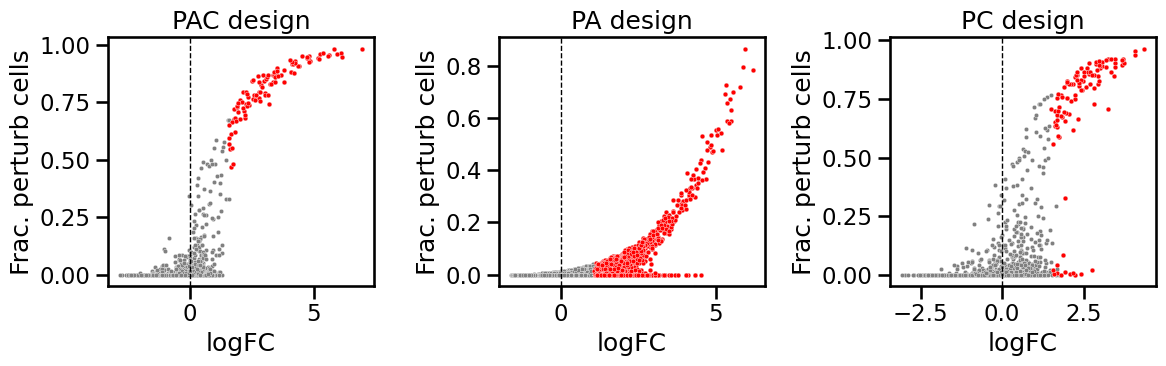

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


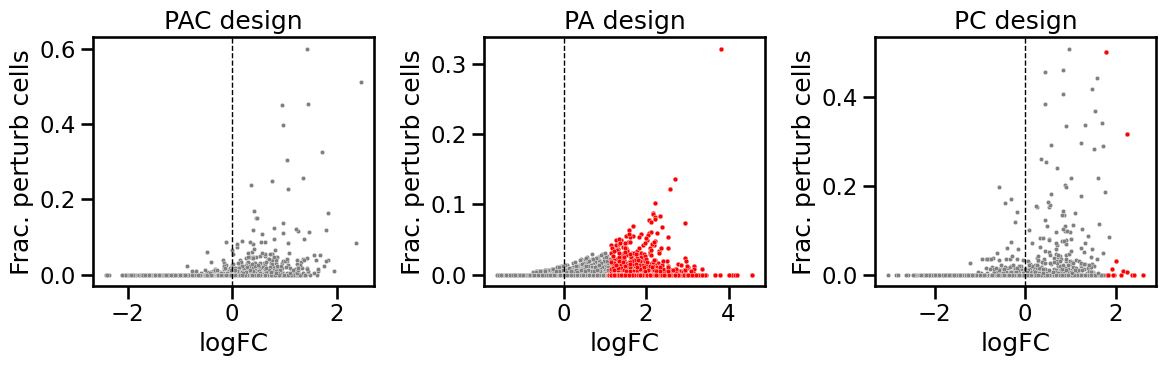

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


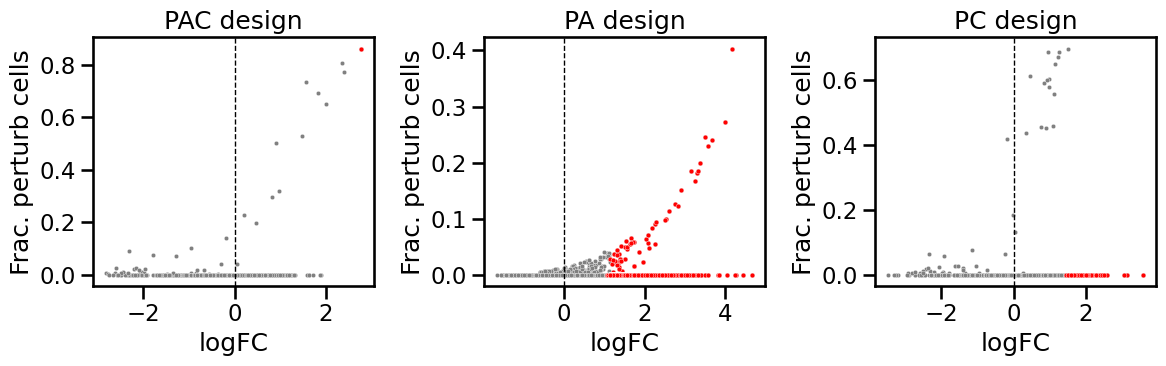

In [31]:
cts = nhood_obs_all.perturb_pop.unique()
for ct in cts:
    nhood_obs = nhood_obs_all[nhood_obs_all.perturb_pop == ct]
    nhood_obs['signif_DA'] = (nhood_obs.SpatialFDR <= 0.1) & (nhood_obs.logFC > 0)
    with rc_context({'figure.figsize':[12,4]}):
        for i,d in enumerate(['PAC', "PA", "PC"]):
            plt.subplot(1,3,i+1)
            sns.scatterplot(data=nhood_obs[nhood_obs.design==d], x='logFC',  y='frac_perturb_cells',  s=10, color='grey');
            sns.scatterplot(data=nhood_obs[(nhood_obs.design==d) & (nhood_obs.signif_DA)], x='logFC',  y='frac_perturb_cells',  s=12, color='red');
            plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
            plt.title(f'{d} design');
            plt.ylabel("Frac. perturb cells");
            plt.tight_layout();
    plt.savefig(figdir + f'N_cells_logFC_{ct}.png');
    plt.show()

In [72]:
%%R -h 1000 -w 1000 
nhood_obs_all %>%
mutate(is_signif = SpatialFDR <= 0.1 & logFC > 0) %>%
ggplot(aes(design, n_perturb_cells,color=is_signif)) +
geom_boxplot() +
facet_wrap(perturb_pop~., scales='free_y')


Error in mutate(., is_signif = SpatialFDR <= 0.1 & logFC > 0) : 
  object 'nhood_obs_all' not found


## Uncertainty delta in PAC across simulations

In [143]:
def add_nhood_uncertainties(pac_design_adata, query_group, ctrl_group):
    pac_design_adata.obs['uncertainty_z'] = 1 - _gauss_kernel(pac_design_adata.obs['uncertainty_z'])
    pac_design_adata.obs['conf_labels'] = 1 - pac_design_adata.obs['uncertainty_labels']
    pac_design_adata.obs['conf_gex'] = 1 - pac_design_adata.obs['uncertainty_gex']
    pac_design_adata.obs['conf_z'] = 1 - pac_design_adata.obs['uncertainty_z']

    for c in ['conf_gex', 'conf_labels', 'conf_z']:
        get_nhood_adata(pac_design_adata).obs[c + '_query'] = get_mean_confidence_x_nhood(
            pac_design_adata, 
            obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] == query_group], confidence_col=c)
        get_nhood_adata(pac_design_adata).obs[c + '_ctrl'] = get_mean_confidence_x_nhood(
            pac_design_adata, 
            obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] == ctrl_group], confidence_col=c)

nhood_obs_all_unc = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if not x.endswith('.h5ad')]:
    perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad', backed=True)
    
    ### Define true positive neighbourhoods
    _add_perturb_pop_info(pac_design_adata)
    
    # ## Calculate avg confidence per nhood
    print(f'Calculating avg confidence')
    add_nhood_uncertainties(pac_design_adata, query_group='query', ctrl_group='ctrl')
    
    ## Store nhood info
    nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
    nhood_obs['perturb_pop'] = perturb_pop
    nhood_obs_all_unc = pd.concat([nhood_obs_all_unc, nhood_obs])

Reading naive_B_cell

Calculating avg confidence
Reading CD14_positive_monocyte

Calculating avg confidence
Reading platelet

Calculating avg confidence
Reading mature_NK_T_cell



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Calculating avg confidence


In [144]:
%%R -i nhood_obs_all_unc
colnames(nhood_obs_all_unc)

 [1] "index_cell"            "kth_distance"          "nhood_annotation"     
 [4] "nhood_annotation_frac" "logFC"                 "logCPM"               
 [7] "F"                     "PValue"                "FDR"                  
[10] "SpatialFDR"            "is_perturb_nhood"      "n_perturb_cells"      
[13] "conf_gex_query"        "conf_gex_ctrl"         "conf_labels_query"    
[16] "conf_labels_ctrl"      "conf_z_query"          "conf_z_ctrl"          
[19] "perturb_pop"          


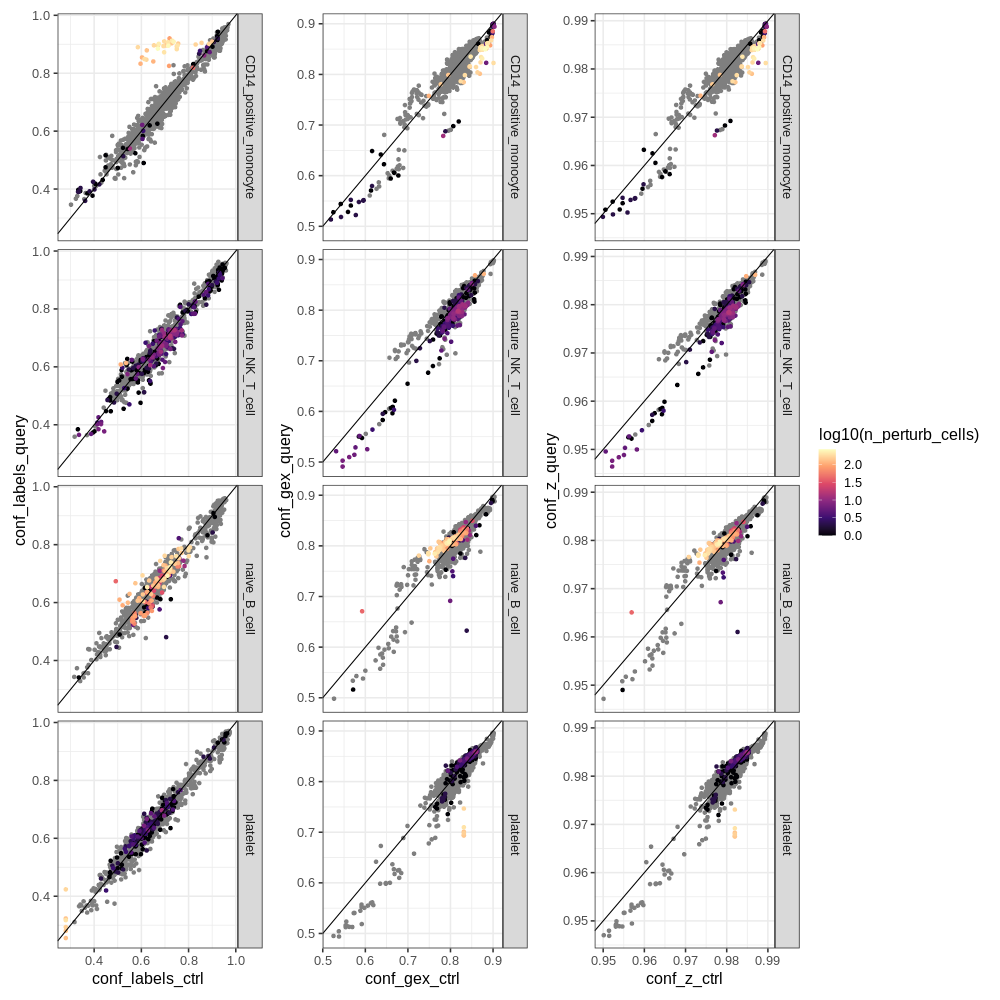

In [153]:
%%R -w 1000 -h 1000

nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_labels_ctrl > 0) %>%
ggplot(aes(conf_labels_ctrl, conf_labels_query, color=log10(n_perturb_cells))) +
    geom_point() +
    geom_abline() +
    scale_color_viridis_c(option='magma') +
    facet_grid(perturb_pop~.) +
    theme_bw(base_size=16) +

nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_gex_ctrl > 0) %>%
ggplot(aes(conf_gex_ctrl, conf_gex_query, color=log10(n_perturb_cells))) +
    geom_point() +
    geom_abline() +
    scale_color_viridis_c(option='magma') +
    facet_grid(perturb_pop~.) +
    theme_bw(base_size=16) +


nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_z_ctrl > 0) %>%
ggplot(aes(conf_z_ctrl, conf_z_query, color=log10(n_perturb_cells))) +
    geom_point() +
    geom_abline() +
    scale_color_viridis_c(option='magma') +
    facet_grid(perturb_pop~.) +
    theme_bw(base_size=16) +
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'confidence_delta_scatter.png'), height=15, width=18)

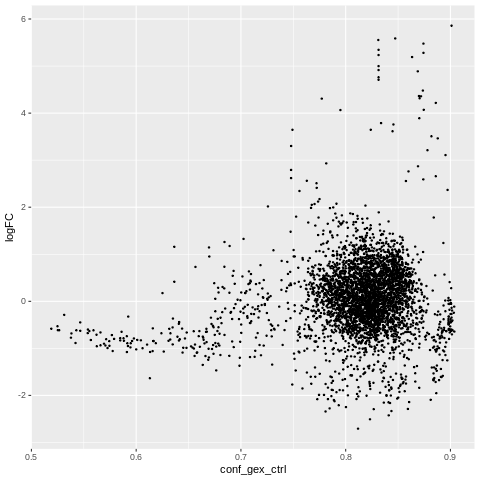

In [172]:
%%R 
nhood_obs_all_unc %>%
filter(conf_gex_ctrl > 0) %>%
ggplot(aes(conf_gex_ctrl, logFC)) +
geom_point(size=0.5) 

Compute Augur AUC for 3 designs
---

In [9]:
perturb_pop='mature_NK_T_cell'
d = f'qPBMC_500cells_demo_perturb_cell_type{perturb_pop}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

population_obs = 'cell_type'
perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
print(f'Reading {perturb_pop}\n')
pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad')
pc_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pc_design.h5ad')
pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad')

Reading mature_NK_T_cell



In [33]:
pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad')
## Restrict nhoods in PA design to where there is at least 20 query cell 
keep_nhoods = pa_design_adata[pa_design_adata.obs['is_query']].obsm['nhoods'].toarray().sum(0) > 10
pa_design_adata.obsm['nhoods'] = pa_design_adata.obsm['nhoods'][:,keep_nhoods]
pa_design_adata.uns['nhood_adata'] = pa_design_adata.uns['nhood_adata'][keep_nhoods].copy()


In [12]:
import diff2atlas
diff2atlas.augur_nhoods(pac_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)
diff2atlas.augur_nhoods(pc_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)

Global seed set to 0


it 1
it 2
it 3
it 4
it 1
it 2
it 3
it 4


In [34]:
diff2atlas.augur_nhoods(pa_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/pool.py", line 412, in _handle_workers
    pool._maintain_pool()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/pool.py", line 248, in _maintain_pool
    self._repopulate_pool()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/pool.py", line 241, in _repopulate_pool
    w.start()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_

KeyboardInterrupt: 

In [16]:
_add_perturb_pop_info(pac_design_adata)
_add_perturb_pop_info(pc_design_adata)
_add_perturb_pop_info(pac_design_adata)

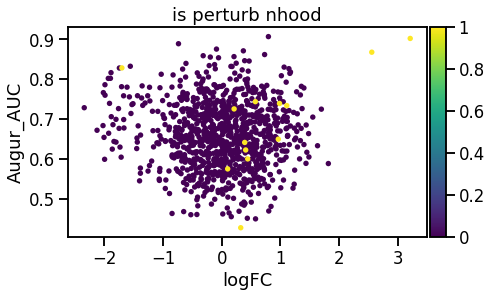

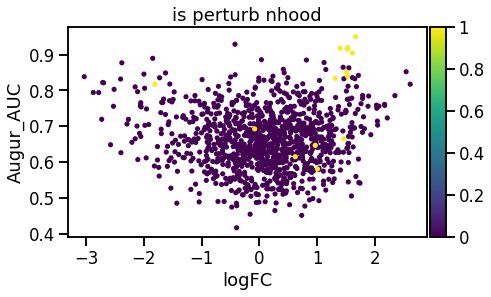

In [17]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC', 'Augur_AUC', color='is_perturb_nhood')
sc.pl.scatter(get_nhood_adata(pc_design_adata), 'logFC', 'Augur_AUC', color='is_perturb_nhood')

---
### Testing zone 

In [11]:
perturb_pop='mature_NK_T_cell'
d = f'qPBMC_500cells_demo_perturb_cell_type{perturb_pop}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

In [12]:
population_obs = 'cell_type'
perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
print(f'Reading {perturb_pop}\n')
pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad')

Reading mature_NK_T_cell



In [13]:
sc.tl.umap(pac_design_adata)

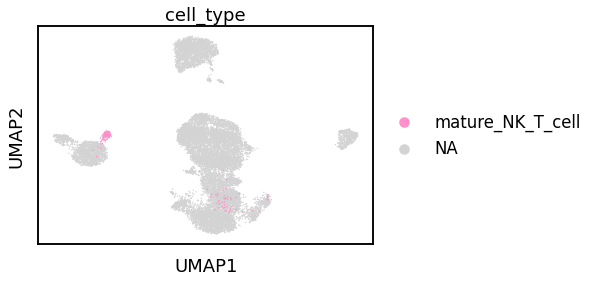

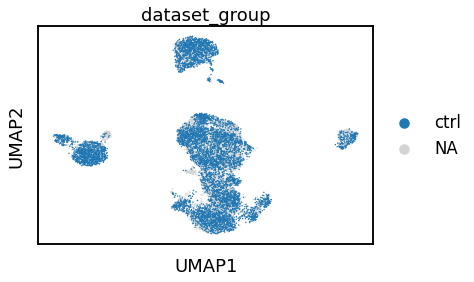

In [14]:
sc.pl.umap(pac_design_adata, color=population_obs, groups=[perturb_pop])
sc.pl.umap(pac_design_adata, color='dataset_group', groups='ctrl')

In [15]:
milopy.utils.build_nhood_graph(pac_design_adata)

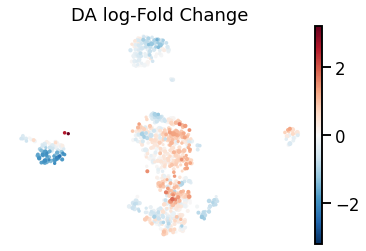

In [16]:
milopy.plot.plot_nhood_graph(pac_design_adata, min_size=0.3, alpha=1)

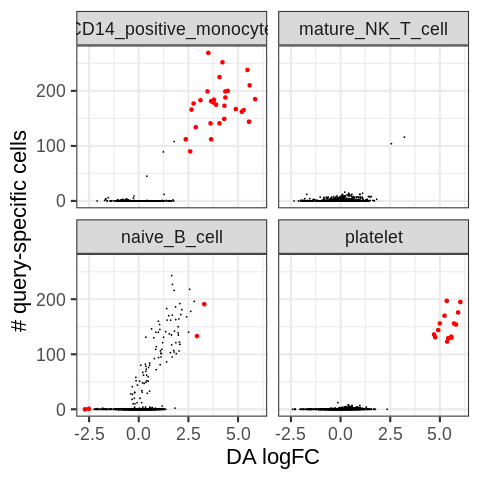

In [248]:
%%R 
nhood_obs_all %>%
filter(design == 'PAC') %>%
mutate(is_signif=SpatialFDR <= 0.1) %>%
ggplot(aes(logFC, n_perturb_cells)) +
geom_point(size=0.2) +
geom_point(data=. %>% filter(is_signif), color='red') +
facet_wrap(perturb_pop~.) +
theme_bw(base_size=22) +
ylab('# query-specific cells') + 
xlab('DA logFC') +
ggsave(paste0(figdir, 'n_perturb_cells.png'), height=8, width=9)

In [17]:
# def basic_AUGUR(nhood)
import diff2atlas
import anndata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def _nhood_augur(params):
    Y_nhood, X_nhood,test_size,subsample = params

    ## Feature selection
    hvgs = sc.pp.highly_variable_genes(anndata.AnnData(X_nhood), inplace=False)
    X_nhood = X_nhood[:,hvgs['highly_variable']]

    ## Split in train and test with subsampling 
    pos_ixs = np.where(Y_nhood==1)[0]
    neg_ixs = np.where(Y_nhood==0)[0]
    if subsample is not None:
        pos_ixs = np.random.choice(pos_ixs, subsample)
        neg_ixs = np.random.choice(neg_ixs, subsample)

    pos_train, pos_test = train_test_split(pos_ixs, test_size=test_size)
    neg_train, neg_test = train_test_split(neg_ixs, test_size=test_size)
    X_train = X_nhood[np.hstack([pos_train, neg_train]),:]
    X_test = X_nhood[np.hstack([pos_test, neg_test]),:]
    Y_train = Y_nhood[np.hstack([pos_train, neg_train])]
    Y_test = Y_nhood[np.hstack([pos_test, neg_test])]

    ## Train classifier on train
    est = LogisticRegression(penalty='l2', random_state=None)
    est.fit(X_train, Y_train)

    ## Predict in test
    Y_pred = est.predict(X_test)

    ## Compute AUC
    nhood_auc = roc_auc_score(Y_test, Y_pred)
    return(nhood_auc)

Global seed set to 0


In [18]:
condition_covariate = 'dataset_group'
ref_level = 'query'

Y = (pac_design_adata.obs[test_covariate] == ref_level).astype('int').values

if 'log1p' not in pac_design_adata.uns.keys():
    pac_design_adata.layers['counts'] = pac_design_adata.X.copy()
    sc.pp.normalize_per_cell(pac_design_adata)
    sc.pp.log1p(pac_design_adata)
# sc.pp.highly_variable_genes(pac_design_adata, subset=False)
# X = pac_design_adata[:,pac_design_adata.var.highly_variable].X.copy()
X = pac_design_adata.X.copy()


In [63]:
def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

nhood_mat = pac_design_adata.obsm['nhoods'].toarray()

nhood_mat_ref = nhood_mat[Y == 1,:]
nhood_mat_ctrl = nhood_mat[Y == 0,:]

[get_cells_from_nhood(pac_design_adata, 1)]

array([False, False, False, ..., False, False, False])

In [119]:
subsample=20
subsamples = []
for i in range(pac_design_adata.obsm['nhoods'].shape[1]): 
    pos_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==1))[0]
    neg_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==0))[0]
    if subsample is not None:
        pos_ixs = np.random.choice(pos_ixs, subsample)
        neg_ixs = np.random.choice(neg_ixs, subsample)
    subsamples.append(np.hstack([pos_ixs, neg_ixs]))
nhoods_sample_ixs = np.vstack(subsamples)

In [121]:
inputs = [(Y[nhoods_sample_ixs[i,:]], X[nhoods_sample_ixs[i,:],:], 0.33, 20) for i in range(nhoods_sample_ixs.shape[0])]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
import multiprocessing
pool = multiprocessing.Pool(10)
inputs = [(Y[nhoods_sample_ixs[i,:]], X[nhoods_sample_ixs[i,:],:], 0.33, 20) for i in range(nhoods_sample_ixs.shape[0])]

## Do 5-fold CV dei poveri 
aucs = np.array(pool.map(_nhood_augur, inputs))
for i in range(4):
    print(f'it {i+1}')
    aucs_i = np.array(pool.map(_nhood_augur, inputs))
    aucs = np.vstack([aucs, aucs_i])
    

it 1
it 2
it 3
it 4


In [42]:
get_nhood_adata(pac_design_adata).obs['Augur_AUC'] = aucs.mean(0)
get_nhood_adata(pac_design_adata).obs['size'] = pac_design_adata.obsm['nhoods'].toarray().sum(0)

(array([  7.,  37.,  77., 106., 227., 289., 147.,  94.,  25.,   7.]),
 array([0.47142857, 0.51428571, 0.55714286, 0.6       , 0.64285714,
        0.68571429, 0.72857143, 0.77142857, 0.81428571, 0.85714286,
        0.9       ]),
 <BarContainer object of 10 artists>)

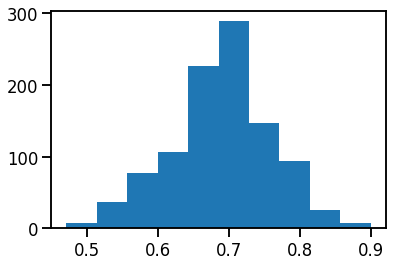

In [43]:
plt.hist(get_nhood_adata(pac_design_adata).obs['Augur_AUC'])

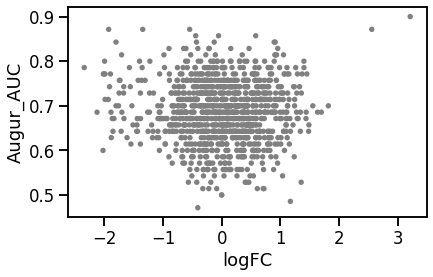

In [44]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC', 'Augur_AUC')

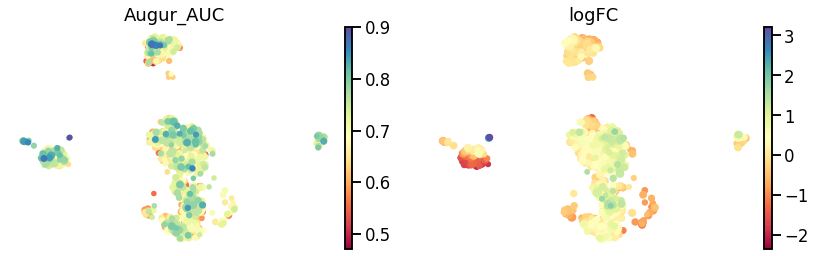

In [47]:
diff2atlas.plotting.plot_nhood_graph(pac_design_adata, color=['Augur_AUC', 'logFC'], min_size=1, cmap='Spectral')

In [123]:
def augur_nhoods(adata,                   
                test_covariate: str,
                ref_level: str = None,
                n_folds: int = 5,
                sample_size: int = 20,
                n_workers: int = 5 
                ) -> None:
    """Compute Augur

    Params:
    ------
    - adata: AnnData object
    - test_covariate: which covariate stores the condition of interest 
    - ref_level: which level of test_covariate to set to 1
    - n_folds: how many permutations to compute AUC on
    - sample_size: how many cells from each condition to downsample to 
        (crucial, otherwise AUC dependent on no of cells from each condition in nhood) 
    - n_workers: for multiprocessing 
    """
    try:
        nhood_adata = adata.uns['nhood_adata'].copy()
    except:
        raise ValueError(
            "adata.uns['nhood_adata'] not found -- please run nhood_confidence first")

    Y = (pac_design_adata.obs[test_covariate] == ref_level).astype('int').values

    if 'log1p' not in pac_design_adata.uns.keys():
        pac_design_adata.layers['counts'] = pac_design_adata.X.copy()
        sc.pp.normalize_per_cell(pac_design_adata)
        sc.pp.log1p(pac_design_adata)
    
    X = pac_design_adata.X.copy()

    ### Make array w nhood x cell indexes (sample subsample of cells x nhood)
    subsamples = []
    for i in range(pac_design_adata.obsm['nhoods'].shape[1]): 
        pos_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==1))[0]
        neg_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==0))[0]
        
        pos_ixs = np.random.choice(pos_ixs, sample_size)
        neg_ixs = np.random.choice(neg_ixs, sample_size)
        subsamples.append(np.hstack([pos_ixs, neg_ixs]))
    nhoods_sample_ixs = np.vstack(subsamples)

    pool = multiprocessing.Pool(n_workers)
    inputs = [(Y[nhoods_sample_ixs[i,:]], X[nhoods_sample_ixs[i,:],:], 0.33) for i in range(nhoods_sample_ixs.shape[0])]

    ## Do 5-fold CV dei poveri 
    aucs = np.array(pool.map(_nhood_augur, inputs))
    for i in range(4):
        print(f'it {i+1}')
        aucs_i = np.array(pool.map(_nhood_augur, inputs))
        aucs = np.vstack([aucs, aucs_i])
    
    get_nhood_adata(pac_design_adata).obs['Augur_AUC'] = aucs.mean(0)
    



def _nhood_augur(params):
    Y_nhood, X_nhood, test_size = params

    ## Feature selection
    hvgs = sc.pp.highly_variable_genes(anndata.AnnData(X_nhood), inplace=False)
    X_nhood = X_nhood[:,hvgs['highly_variable']]

    ## Split in train and test with subsampling 
    X_train, X_test, Y_train, Y_test = train_test_split(X_nhood, Y_nhood, test_size=test_size)
    
    ## Train classifier on train
    est = LogisticRegression(penalty='l2', random_state=None)
    est.fit(X_train, Y_train)

    ## Predict in test
    Y_pred = est.predict(X_test)

    ## Compute AUC
    nhood_auc = roc_auc_score(Y_test, Y_pred)
    return(nhood_auc)

In [125]:

augur_nhoods(pac_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)

it 1
it 2
it 3
it 4


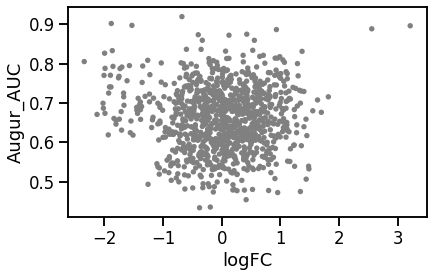

In [128]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC', 'Augur_AUC')

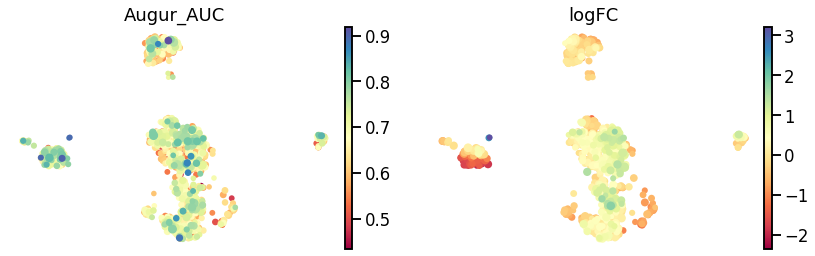

In [129]:
diff2atlas.plotting.plot_nhood_graph(pac_design_adata, color=['Augur_AUC', 'logFC'], min_size=1, cmap='Spectral')
